# Predicción de Lluvia en Australia

### Facultad de Ciencias Exactas, Ingeniería y Agrimensura  
### Tecnicatura en Inteligencia Artificial  
### Aprendizaje Automático 1  

**Trabajo Práctico**: Predicción de lluvia utilizando modelos de clasificación y redes neuronales.

**Autores**:  
- Avecilla Tomás (A-4239/9)
- Calcia Franco (C-7363/2)

 

---

### Objetivo
Desarrollar un modelo de predicción de la variable `RainTomorrow` basado en datos climáticos de Australia, utilizando técnicas de pre-procesamiento, modelado, evaluación y optimización de modelos, para su posterior puesta en producción.



### Diccionario de Datos

| Variable         | Descripción                                                       | Tipo        | Ejemplo       
|-------------------|------------------------------------------------------------------|-------------|---------------
| **Date**          | Fecha de la observación del clima.                               | object      | 2010-01-01    
| **Location**      | Ciudad donde se realizó la medición del clima.                  | object      | Sydney        
| **MinTemp**       | Temperatura mínima del día (en grados Celsius).                 | float64     | 12.3          
| **MaxTemp**       | Temperatura máxima del día (en grados Celsius).                 | float64     | 28.9          
| **Rainfall**      | Cantidad de lluvia caída en milímetros durante el día.          | float64     | 0.0           
| **Evaporation**   | Evaporación en milímetros durante el día.                       | float64     | 0.0           
| **Sunshine**      | Horas de sol durante el día.                                    | float64     | 8.0           
| **WindGustDir**   | Dirección del viento racheado (en grados).                      | object      | NNE           
| **WindGustSpeed** | Velocidad del viento racheado (en km/h).                        | float64     | 15.0          
| **WindDir9am**    | Dirección del viento a las 9 am.                                | object      | NNE           
| **WindDir3pm**    | Dirección del viento a las 3 pm.                                | object      | SSE          
| **WindSpeed9am**  | Velocidad del viento a las 9 am (en km/h).                     | float64     | 5.0           
| **WindSpeed3pm**  | Velocidad del viento a las 3 pm (en km/h).                     | float64     | 10.0          
| **Humidity9am**   | Humedad relativa a las 9 am (%).                               | float64     | 65.0          
| **Humidity3pm**   | Humedad relativa a las 3 pm (%).                               | float64     | 55.0          
| **Pressure9am**   | Presión atmosférica a las 9 am (hPa).                          | float64     | 1012.0        
| **Pressure3pm**   | Presión atmosférica a las 3 pm (hPa).                          | float64     | 1011.0        
| **Cloud9am**      | Cobertura nubosa a las 9 am (en octavos).                      | float64     | 2.0           
| **Cloud3pm**      | Cobertura nubosa a las 3 pm (en octavos).                      | float64     | 3.0           
| **Temp9am**       | Temperatura a las 9 am (en grados Celsius).                    | float64     | 15.0          
| **Temp3pm**       | Temperatura a las 3 pm (en grados Celsius).                    | float64     | 20.0          
| **RainToday**     | Indica si llovió hoy (Yes/No).                                 | object      | Yes           
| **RainTomorrow** _(Target)_ | Indica si lloverá mañana (Yes/No).                             | object      | No            


## Preparación del entorno de trabajo

In [2]:
import shap
from pycaret.classification import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
import tensorflow as tf
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import RMSprop, Adam
import pickle

In [3]:
df_clima = pd.read_csv("weatherAUS.csv")

In [4]:
ciudades_aleatorias = df_clima['Location'].sample(n=10, random_state=37)
df_filtered = df_clima[df_clima['Location'].isin(ciudades_aleatorias)]
df_filtered['Location'].value_counts()

Canberra        3436
Albury          3040
Bendigo         3040
Penrith         3039
Tuggeranong     3039
Woomera         3009
PearceRAAF      3009
PerthAirport    3009
Walpole         3006
Uluru           1578
Name: Location, dtype: int64

## Análisis Descriptivo

In [5]:
df_filtered.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
# Resumen de estadísticas descriptivas
stats = df_filtered.describe().T
stats['missing_values'] = df_filtered.isnull().sum()
stats = stats.round(2)
stats.head(35)


,count,mean,std,min,25%,50%,75%,max,missing_values
MinTemp,29061.0,10.68,6.24,-8.2,6.40,10.8,15.1,31.8,144
MaxTemp,29087.0,23.62,7.46,2.6,17.80,22.7,28.8,48.1,118
Rainfall,28528.0,1.76,5.88,0.0,0.00,0.0,0.2,115.4,677
Evaporation,8595.0,6.48,5.96,0.0,2.60,5.0,8.8,82.4,20610
Sunshine,9536.0,8.63,3.48,0.0,6.48,9.3,11.3,14.2,19669
WindGustSpeed,28319.0,39.06,13.39,7.0,30.00,39.0,46.0,135.0,886
WindSpeed9am,28801.0,12.83,8.89,0.0,6.00,11.0,19.0,57.0,404
WindSpeed3pm,28834.0,17.42,8.25,0.0,11.00,17.0,22.0,67.0,371
Humidity9am,28899.0,67.03,20.45,0.0,54.00,69.0,82.0,100.0,306
Humidity3pm,28982.0,44.91,20.75,0.0,29.00,44.0,58.0,100.0,223


**Descripción rápida de los datos:**
Este conjunto de datos contiene información meteorológica con un número considerable de valores faltantes. Algunas variables como la evaporación, la luz solar y la cobertura nubosa tienen un porcentaje elevado de datos faltantes, mientras que otras, como la temperatura y la humedad, tienen menos valores nulos.

In [7]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29205 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           29205 non-null  object 
 1   Location       29205 non-null  object 
 2   MinTemp        29061 non-null  float64
 3   MaxTemp        29087 non-null  float64
 4   Rainfall       28528 non-null  float64
 5   Evaporation    8595 non-null   float64
 6   Sunshine       9536 non-null   float64
 7   WindGustDir    28284 non-null  object 
 8   WindGustSpeed  28319 non-null  float64
 9   WindDir9am     26179 non-null  object 
 10  WindDir3pm     28606 non-null  object 
 11  WindSpeed9am   28801 non-null  float64
 12  WindSpeed3pm   28834 non-null  float64
 13  Humidity9am    28899 non-null  float64
 14  Humidity3pm    28982 non-null  float64
 15  Pressure9am    25833 non-null  float64
 16  Pressure3pm    25843 non-null  float64
 17  Cloud9am       13681 non-null  float64
 18  Cloud

El DataFrame contiene 23 columnas, de las cuales 16 son de tipo numérico (float64) y 7 de tipo categórico (object). Como primer paso, convertiremos el tipo de dato de la columna 'Date' a un formato de fecha adecuado y luego ordenaremos el dataset en orden ascendente.

In [8]:
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

df_filtered = df_filtered.sort_values(by='Date', ascending=True)

In [9]:
df_filtered = pd.get_dummies(df_filtered, columns=['RainToday', 'RainTomorrow'], drop_first=True)
# Renombrar las columnas
df_filtered = df_filtered.rename(columns={'RainToday_Yes': 'RainToday', 'RainTomorrow_Yes': 'RainTomorrow'})
# Convertir las columnas RainToday y RainTomorrow a 0 y 1
df_filtered['RainToday'] = df_filtered['RainToday'].astype(int)
df_filtered['RainTomorrow'] = df_filtered['RainTomorrow'].astype(int)

Vamos a analizar el comportamiento de nuestras variables numéricas para identificar tendencias o distribuciones. 

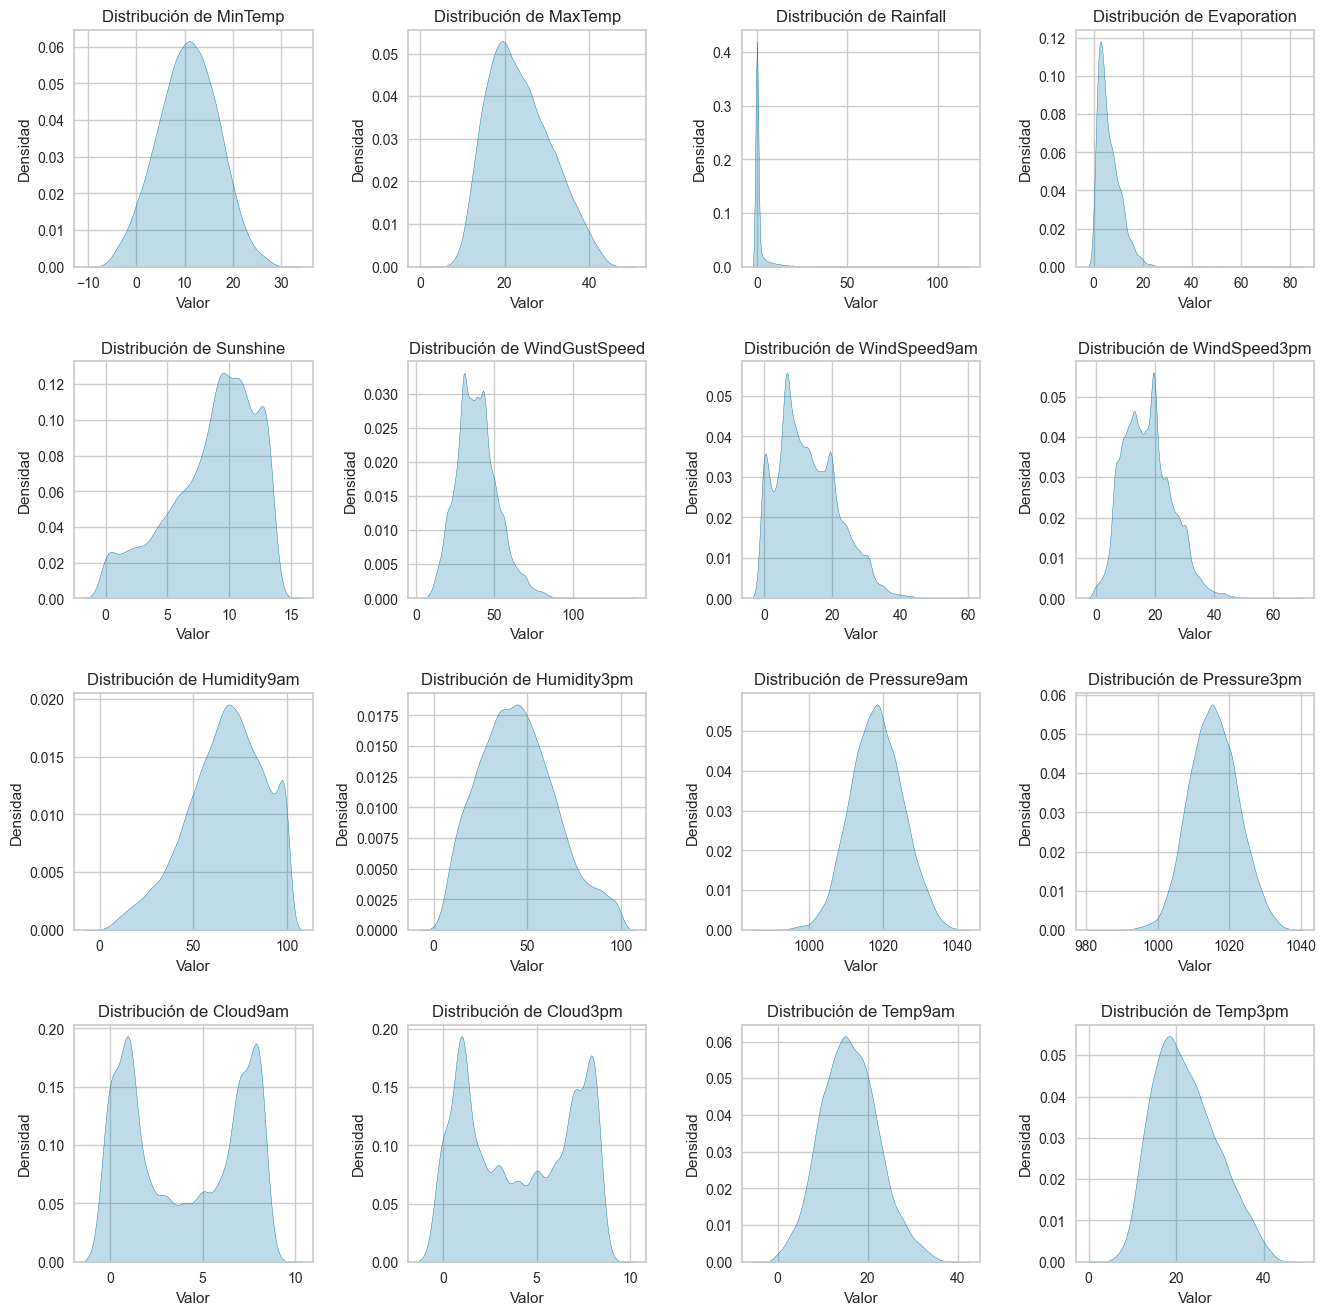

In [10]:
# Filtrar las columnas numéricas del dataframe
df_numerico = df_filtered.select_dtypes(include=['float64', 'int64'])

# Determinar el número de variables numéricas
num_vars = len(df_numerico.columns)

# Configurar la figura y las subplots
fig, axes = plt.subplots(nrows=(num_vars // 4) + (num_vars % 4 > 0), ncols=4, figsize=(16, num_vars))

# Ajustar espacio entre los gráficos
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Recorrer las columnas y plotear cada una en su propio subplot
for i, column in enumerate(df_numerico.columns):
    row, col = divmod(i, 4)
    sns.kdeplot(df_numerico[column], ax=axes[row, col], fill=True)
    axes[row, col].set_title(f'Distribución de {column}')
    axes[row, col].set_xlabel('Valor')
    axes[row, col].set_ylabel('Densidad')

# Eliminar gráficos vacíos si no se llena la última fila
for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()


Al analizar las distribuciones de las variables numéricas a través de gráficos de KDE, observamos varios patrones.

1. **Distribuciones Normales**:
   Algunas variables muestran una distribución simétrica, similar a la curva de campana característica de la **distribución normal**.

2. **Distribuciones Asimétricas (Sesgo)**:
   Otras variables presentan **sesgo**, ya sea positivo o negativo.
   
3. **Distribuciones Multimodales**:
   Se observan algunas variables con **distribuciones multimodales**, es decir, con varios picos en su densidad. Esto podría sugerir la existencia de **subgrupos** lo cual es normal ya que los datos son climaticos y puede llegar a tener algo que ver con las estaciones.

4. **Presencia de Outliers**:
   Varias variables muestran distribuciones con **colas largas**, lo que indica la presencia de **outliers** lo cual nos confirma lo que fue analizado anteriormente.



## Analisis exploratorio

Viendo que las columnas 'WindGustDir', 'WindDir9am' y 'WindDir3pm' son variables categóricas (tipo object), evaluaremos su correlación con nuestra variable objetivo. Esto nos ayudará a decidir si es conveniente eliminarlas o mantenerlas, con el objetivo de reducir la complejidad del modelo y evitar posibles problemas en la etapa de predicción.

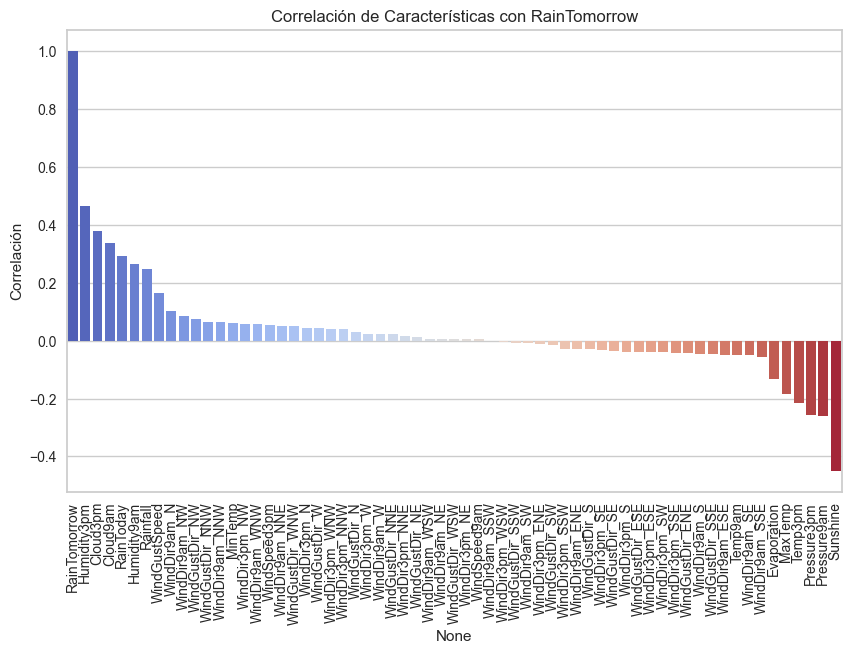

In [11]:
# Eliminar la columna 'Location'
df_without_location = df_filtered.drop(columns=['Location'])
# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df_without_location, columns=['WindGustDir', 'WindDir9am', 'WindDir3pm'], drop_first=True)

# Calcular la matriz de correlación
correlation_matrix = df_encoded.corr()

# Mostrar correlación con 'RainTomorrow'
# Ordenar las correlaciones con 'RainTomorrow'
correlations_with_rain = correlation_matrix['RainTomorrow'].sort_values(ascending=False)

# Crear un gráfico de barras para visualizar la correlación de cada característica con 'RainTomorrow'
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_with_rain.index, y=correlations_with_rain.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Correlación de Características con RainTomorrow')
plt.ylabel('Correlación')
plt.show()

Es evidente que estas variables no tendrían un impacto significativo en el rendimiento del modelo. Por lo tanto, procederemos a eliminarlas para simplificar el conjunto de datos y evitar complicaciones en el proceso de predicción.

In [12]:
columnas = ['WindDir9am', 'WindDir3pm', 'WindGustDir']

# Dropear las columnas
df_filtered = df_filtered.drop(columns=columnas)

Para la variable categórica 'Location', calculamos la proporción de cada localidad en relación con nuestra variable objetivo. Esto nos permitió evaluar cómo cada ubicación podría influir en la predicción.

In [13]:
df_filtered['Location'] = df_filtered['Location'].fillna('Categoria_Nula')

mean_encoded_location_today = df_filtered.groupby('Location')['RainTomorrow'].mean()

df_filtered['Location'] = df_filtered['Location'].map(mean_encoded_location_today)

Al observar los valores faltantes, calculamos el porcentaje de datos faltantes en cada columna. 

In [14]:
conteo_nan = df_filtered.isnull().sum()
# Que porcentaje del total de cada columna hay valores faltantes
nan_percentage = (conteo_nan / len(df_filtered)) * 100
missing_data = pd.DataFrame({'count': conteo_nan, 'percentage': nan_percentage})
print(missing_data)

               count  percentage
Date               0    0.000000
Location           0    0.000000
MinTemp          144    0.493066
MaxTemp          118    0.404040
Rainfall         677    2.318096
Evaporation    20610   70.570108
Sunshine       19669   67.348057
WindGustSpeed    886    3.033727
WindSpeed9am     404    1.383325
WindSpeed3pm     371    1.270330
Humidity9am      306    1.047766
Humidity3pm      223    0.763568
Pressure9am     3372   11.545968
Pressure3pm     3362   11.511727
Cloud9am       15524   53.155282
Cloud3pm       15684   53.703133
Temp9am          151    0.517035
Temp3pm          110    0.376648
RainToday          0    0.000000
RainTomorrow       0    0.000000


Algunas variables, como 'Evaporation', 'Sunshine', 'Cloud9am' y 'Cloud3pm', tienen un porcentaje considerable de datos faltantes, mientras que otras, como 'MinTemp', 'MaxTemp' o 'Rainfall', presentan menos valores faltantes.

### Limpieza de Datos

Como primera medida, eliminaremos las filas que tengan valores nulos en la variable objetivo o aquellas que presenten 18 o más columnas con valores nulos, ya que las consideramos irrelevantes para el análisis.

In [15]:
#Mantenemos las filas que contengan 18 o menos valores nulos
df_filtered = df_filtered.dropna(thresh=18)

#Eliminamos las filas que contienen la variable Target como nula
df_filtered = df_filtered.dropna(subset=['RainTomorrow'])

A continuación, realizaremos la división de los datos, ya que consideramos que es un paso necesario en este punto. Sin embargo, continuaremos con el análisis exploratorio y la limpieza de los datos una vez realizada esta división.

### Train-Test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_filtered.drop(columns=['RainTomorrow']), df_filtered['RainTomorrow'], test_size=0.3, random_state=42)

#Validacion
X_train, X_temp, y_train, y_temp = train_test_split(
    df_filtered.drop(columns=['RainTomorrow']),
    df_filtered['RainTomorrow'],
    test_size=0.3,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5, 
    random_state=42
)

# Concatenar para tener dataframes completos
df_entrenamiento = pd.concat([X_train, y_train], axis=1)
df_validacion = pd.concat([X_val, y_val], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

Decidimos imputar las variables que tienen menos de 1000 valores faltantes utilizando la media, ya que el porcentaje que representan en relación con el total de filas es insignificante y no debería afectar el análisis o los resultados del modelo de manera considerable.

In [17]:
# Identificar las columnas con menos de 1000 nulos
cols_with_few_nans = df_entrenamiento.columns[df_entrenamiento.isnull().sum() < 1000]
medias = {}

for col in cols_with_few_nans:
    if df_entrenamiento[col].dtype in ['float64', 'int64']:  # Solo columnas numéricas
        media = df_entrenamiento[col].mean()  # Calcular la media
        df_entrenamiento[col] = df_entrenamiento[col].fillna(media) 
        medias[col] = media


In [18]:
nan_count_train = df_entrenamiento.isnull().sum()
nan_count_train

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation      3372
Sunshine         3143
WindGustSpeed       0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
dtype: int64

Todavia contamos con columnas que presentan algunos valores nulos. Antes de tomar decisiones sobre cómo manejarlas, analizaremos su distribución para evaluar si es conveniente imputarlas o eliminarlas, con el fin de tomar una decisión informada que no afecte negativamente el análisis o el rendimiento del modelo.

<AxesSubplot: xlabel='Evaporation', ylabel='Density'>

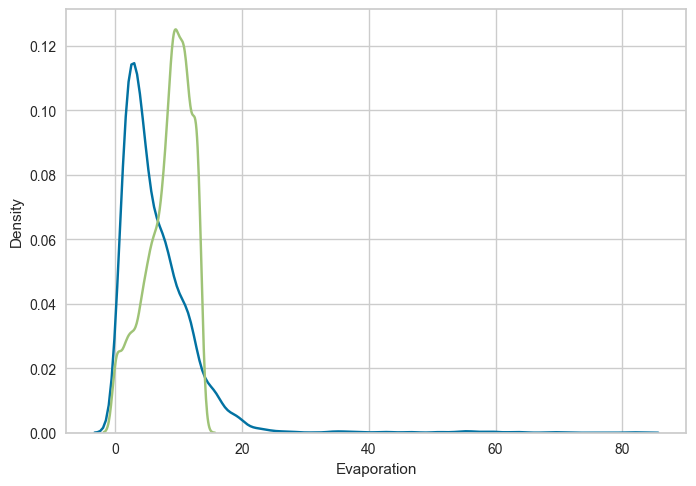

In [19]:
sns.kdeplot(df_entrenamiento["Evaporation"])
sns.kdeplot(df_entrenamiento["Sunshine"])

Podemos observar una clara distribución asimétrica a la derecha. Por lo tanto, optaremos por imputar los valores nulos utilizando la mediana, ya que este enfoque es más robusto frente a los valores atípicos y proporciona una estimación más representativa de los datos.

In [20]:
# Imputar los valores faltantes en 'Evaporation' y 'Sunshine' con la mediana
mediana_evaporation = df_entrenamiento['Evaporation'].median()
mediana_sunshine= df_entrenamiento['Sunshine'].median()

df_entrenamiento['Evaporation'] = df_entrenamiento['Evaporation'].fillna(mediana_evaporation)
df_entrenamiento['Sunshine'] = df_entrenamiento['Sunshine'].fillna(mediana_sunshine)


In [21]:
nan_count_train = df_entrenamiento.isnull().sum()
nan_count_train

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

#### Outliers

In [22]:
resultados_atipicos = {}

for columna in df_entrenamiento.columns:
    if df_entrenamiento[columna].dtype in ['int64', 'float64']:
        Q1 = df_entrenamiento[columna].quantile(0.25)
        Q3 = df_entrenamiento[columna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        es_atipico = (df_entrenamiento[columna] < limite_inferior) | (df_entrenamiento[columna] > limite_superior)

        cantidad_atipicos = es_atipico.sum()
        porcentaje_atipicos = (cantidad_atipicos / len(df_entrenamiento)) * 100

        resultados_atipicos[columna] = porcentaje_atipicos

for columna, porcentaje in resultados_atipicos.items():
    print(f"Columna: {columna} - Porcentaje de valores atípicos: {porcentaje:.2f}%")

Columna: Location - Porcentaje de valores atípicos: 22.40%
Columna: MinTemp - Porcentaje de valores atípicos: 0.19%
Columna: MaxTemp - Porcentaje de valores atípicos: 0.08%
Columna: Rainfall - Porcentaje de valores atípicos: 20.74%
Columna: Evaporation - Porcentaje de valores atípicos: 11.68%
Columna: Sunshine - Porcentaje de valores atípicos: 14.30%
Columna: WindGustSpeed - Porcentaje de valores atípicos: 1.69%
Columna: WindSpeed9am - Porcentaje de valores atípicos: 0.42%
Columna: WindSpeed3pm - Porcentaje de valores atípicos: 0.59%
Columna: Humidity9am - Porcentaje de valores atípicos: 0.00%
Columna: Humidity3pm - Porcentaje de valores atípicos: 0.18%
Columna: Pressure9am - Porcentaje de valores atípicos: 0.54%
Columna: Pressure3pm - Porcentaje de valores atípicos: 0.53%
Columna: Cloud9am - Porcentaje de valores atípicos: 0.00%
Columna: Cloud3pm - Porcentaje de valores atípicos: 0.00%
Columna: Temp9am - Porcentaje de valores atípicos: 0.41%
Columna: Temp3pm - Porcentaje de valores at

Observamos que en la mayoría de las columnas no hay una cantidad significativa de valores atípicos, por lo que decidimos no realizar ningún tratamiento sobre ellos.

A continuación, analizaremos la distribución de la variable objetivo.

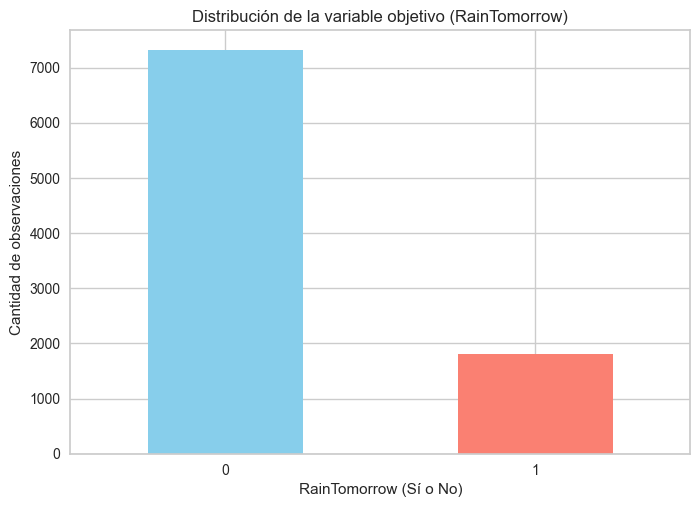

In [23]:
df_entrenamiento['RainTomorrow'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])

plt.title('Distribución de la variable objetivo (RainTomorrow)')
plt.xlabel('RainTomorrow (Sí o No)')
plt.ylabel('Cantidad de observaciones')
plt.xticks(rotation=0)
plt.show()


Observamos una marcada diferencia entre los dos valores de la variable objetivo, lo que indica que el conjunto de datos **está desbalanceado**, lo cual mas adelante procederemos a balancearlo. Además, es importante analizar la tasa de aciertos en las predicciones del dataset.

True     6238
False    2883
Name: Predicción Acertada, dtype: int64


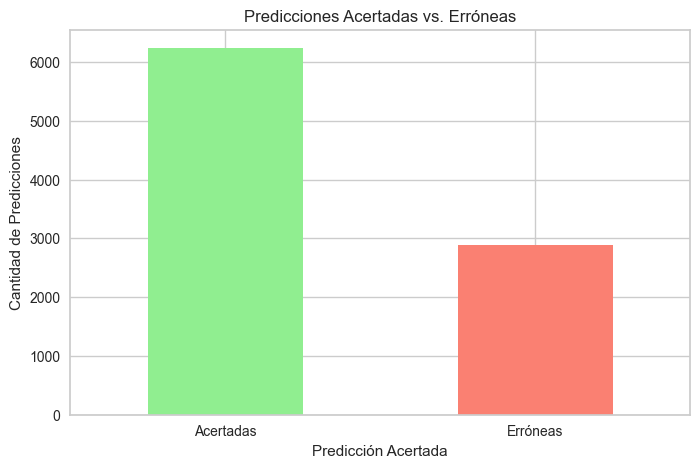

In [24]:
# Crear una copia de las columnas relevantes
df_aciertos = df_entrenamiento[['RainToday', 'RainTomorrow']].copy()

# Comparar RainToday de la fila actual con RainTomorrow de la fila anterior
# shift() mueve la columna RainTomorrow una fila hacia abajo
df_aciertos['Predicción Acertada'] = df_aciertos['RainToday'] == df_aciertos['RainTomorrow'].shift(1)

# Contar las predicciones acertadas y erróneas
conteo_aciertos = df_aciertos['Predicción Acertada'].value_counts()

# Mostrar conteo de aciertos
print(conteo_aciertos)

# Graficar los resultados
plt.figure(figsize=(8, 5))
conteo_aciertos.plot(kind='bar', color=['lightgreen', 'salmon'])

plt.title('Predicciones Acertadas vs. Erróneas')
plt.xlabel('Predicción Acertada')
plt.ylabel('Cantidad de Predicciones')
plt.xticks(ticks=[0, 1], labels=['Acertadas', 'Erróneas'], rotation=0)

plt.show()


Considerando la información proporcionada por las variables, analizamos la precisión de las 'predicciones' sobre si lloverá mañana. Observamos que se ha logrado una predicción con cierto grado de efectividad, aunque hay margen para mejorar.

### Matriz de correlación


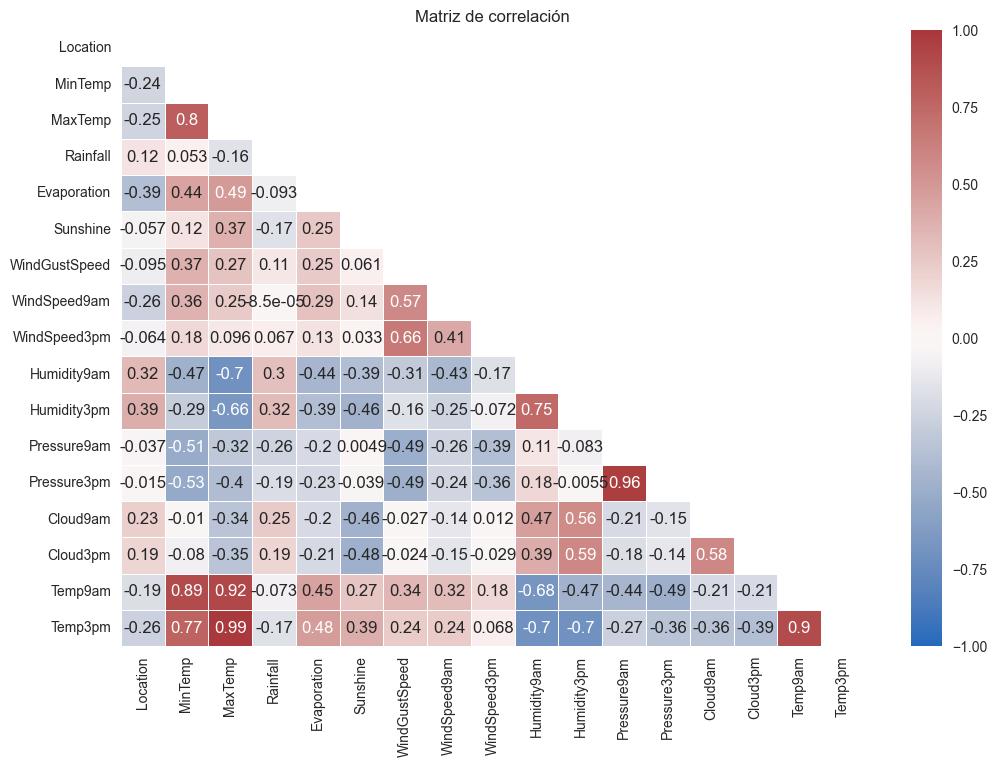

In [25]:
df_numerico = df_entrenamiento.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
corr_matrix = df_numerico.corr()

# Crear la máscara
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Crear el colormap
colors = [(1, 1, 1), (1, 0, 0)]
n_bins = 100
cmap_name = 'red_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Graficar el heatmap de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='vlag', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()


Decidimos eliminar las columnas 'Temp9am' y 'Temp3pm', ya que contamos con 'MinTemp' y 'MaxTemp' para todo el día, y su correlación sugiere que son redundantes. De manera similar, considerando la correlación entre 'Pressure9am' y 'Pressure3pm', optamos por conservar solo una de ellas.

In [26]:
df_entrenamiento = df_entrenamiento.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am'])

### Limpieza de datos para df_test y df_validacion

Todas las imputaciones y limpiezas de datos que realizamos para el conjunto de entrenamiento también se aplicarán a los conjuntos de prueba y validación, asegurando consistencia en el procesamiento de los datos.

In [27]:
for col, media in medias.items():
    if col in df_validacion.columns:   
        df_validacion[col] = df_validacion[col].fillna(media)  
for col, media in medias.items():
    if col in df_test.columns:  
        df_test[col] = df_test[col].fillna(media)


df_test["Evaporation"] = df_test["Evaporation"].fillna(mediana_evaporation)
df_test["Sunshine"] = df_test["Sunshine"].fillna(mediana_sunshine)
df_validacion["Evaporation"] = df_validacion["Evaporation"].fillna(mediana_evaporation)
df_validacion["Sunshine"] = df_validacion["Sunshine"].fillna(mediana_sunshine)


df_test = df_test.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am'])
df_validacion = df_validacion.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am'])


Finalmente, para mejorar nuestras predicciones futuras, decidimos dividir la columna 'Date' en componentes como mes, día, año, día de la semana y día del año. No realizamos esta división anteriormente para evitar que se mostrara en la matriz de correlación.

In [28]:
# Extraer características de fecha para df_entrenamiento
df_entrenamiento['Year'] = df_entrenamiento['Date'].dt.year
df_entrenamiento['Month'] = df_entrenamiento['Date'].dt.month
df_entrenamiento['Day'] = df_entrenamiento['Date'].dt.day
df_entrenamiento['DayOfWeek'] = df_entrenamiento['Date'].dt.dayofweek  # Lunes = 0, Domingo = 6
df_entrenamiento['DayOfYear'] = df_entrenamiento['Date'].dt.dayofyear

# Extraer características de fecha para df_validacion
df_validacion['Year'] = df_validacion['Date'].dt.year
df_validacion['Month'] = df_validacion['Date'].dt.month
df_validacion['Day'] = df_validacion['Date'].dt.day
df_validacion['DayOfWeek'] = df_validacion['Date'].dt.dayofweek  # Lunes = 0, Domingo = 6
df_validacion['DayOfYear'] = df_validacion['Date'].dt.dayofyear

# Extraer características de fecha para df_test
df_test['Year'] = df_test['Date'].dt.year
df_test['Month'] = df_test['Date'].dt.month
df_test['Day'] = df_test['Date'].dt.day
df_test['DayOfWeek'] = df_test['Date'].dt.dayofweek  # Lunes = 0, Domingo = 6
df_test['DayOfYear'] = df_test['Date'].dt.dayofyear

# Dropear la columna 'Date' de df_entrenamiento
df_entrenamiento = df_entrenamiento.drop(columns=['Date'])

# Dropear la columna 'Date' de df_validacion
df_validacion = df_validacion.drop(columns=['Date'])

# Dropear la columna 'Date' de df_test
df_test = df_test.drop(columns=['Date'])

In [29]:
df_entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9121 entries, 108526 to 119107
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       9121 non-null   float64
 1   MinTemp        9121 non-null   float64
 2   MaxTemp        9121 non-null   float64
 3   Rainfall       9121 non-null   float64
 4   Evaporation    9121 non-null   float64
 5   Sunshine       9121 non-null   float64
 6   WindGustSpeed  9121 non-null   float64
 7   WindSpeed9am   9121 non-null   float64
 8   WindSpeed3pm   9121 non-null   float64
 9   Humidity9am    9121 non-null   float64
 10  Humidity3pm    9121 non-null   float64
 11  Pressure3pm    9121 non-null   float64
 12  Cloud9am       9121 non-null   float64
 13  Cloud3pm       9121 non-null   float64
 14  RainToday      9121 non-null   int32  
 15  RainTomorrow   9121 non-null   int32  
 16  Year           9121 non-null   int64  
 17  Month          9121 non-null   int64  
 18  D

## Escalado

Optamos por utilizar **RobustScaler** debido a que aún contamos con algunos valores atípicos. Esto permitirá que el algoritmo de aprendizaje automático sea más estable.

In [30]:
scaler = RobustScaler()

df_train_scaled = pd.DataFrame(scaler.fit_transform(df_entrenamiento), columns=df_entrenamiento.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)
df_val_scaled = pd.DataFrame(scaler.transform(df_validacion), columns=df_validacion.columns)

df_train_scaled.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,Year,Month,Day,DayOfWeek,DayOfYear
0,-5.626333,-0.206897,0.111111,0.0,-0.538462,0.00,-0.352941,0.000000,-0.307692,-0.59375,...,0.369565,0.014714,0.000000,0.0,0.0,1.0,-0.2,-0.266667,0.25,-0.260355
1,-0.739236,-0.459770,0.074074,0.0,0.000000,0.80,-0.588235,0.000000,-0.769231,0.43750,...,0.510870,0.348047,-0.016965,0.0,0.0,0.4,0.6,-0.066667,-0.75,0.485207
2,-0.739236,0.471264,0.435185,4.5,0.000000,0.00,-0.117647,0.153846,0.230769,0.21875,...,-0.652174,0.014714,-0.016965,1.0,0.0,-0.6,0.8,0.733333,-0.50,0.733728
3,0.000000,-0.919540,-0.787037,0.0,-1.461538,-4.60,1.705882,-1.153846,-0.923077,0.78125,...,-0.217391,0.681381,0.649702,0.0,1.0,-0.4,0.2,-0.200000,-0.50,0.106509
4,0.000000,0.137931,0.166667,1.0,-1.461538,-0.85,-0.882353,-0.692308,-0.769231,0.25000,...,0.413043,0.514714,0.149702,0.0,0.0,-1.0,1.0,0.533333,0.50,0.899408


## Modelado

In [31]:
X_train_scaled = df_train_scaled.drop('RainTomorrow', axis=1)
y_train_scaled = df_train_scaled['RainTomorrow']

X_test_scaled = df_test_scaled.drop('RainTomorrow', axis=1)
y_test_scaled = df_test_scaled['RainTomorrow']

X_val_scaled = df_val_scaled.drop('RainTomorrow', axis=1)
y_val_scaled = df_val_scaled['RainTomorrow']

### Previo al balanceo

Vamos a evaluar las métricas del dataset antes de balancearlo. Luego, realizaremos el balanceo y compararemos los resultados.

Aplicamos 'LogisticRegression'

In [32]:
# Inicializar y entrenar el modelo
model = LogisticRegression()
model.fit(X_train_scaled, y_train_scaled)

LogisticRegression()

Procedemos a calcular nuestras métricas adecuadas.

In [33]:
# Predicciones
y_pred = model.predict(X_test_scaled)  
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Cálculo de métricas
accuracy = accuracy_score(y_test_scaled, y_pred)
precision = precision_score(y_test_scaled, y_pred)
recall = recall_score(y_test_scaled, y_pred)
f1 = f1_score(y_test_scaled, y_pred)

# Mostrar las métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.87
Precision: 0.75
Recall: 0.54
F1 Score: 0.63


Calculamos nuestra curva ROC

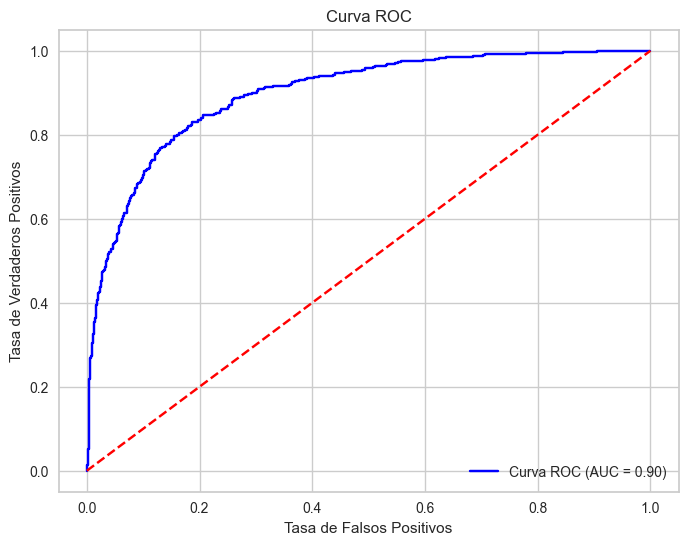

Mejor umbral: 0.20


In [34]:
# Cálculo de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_scaled, y_pred_proba)
roc_auc = roc_auc_score(y_test_scaled, y_pred_proba)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Encontrar el mejor umbral
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Mejor umbral: {optimal_threshold:.2f}")

Verificamos la matriz de confusión

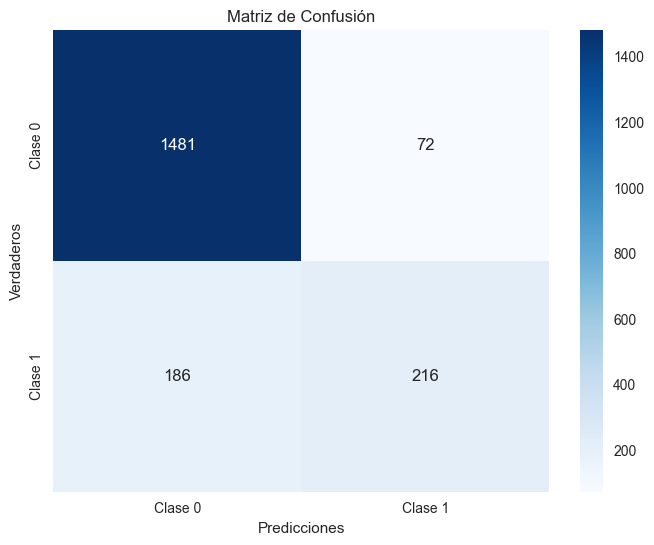

In [35]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test_scaled, y_pred)
# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1'], 
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()

### Posterior al balanceo

Aplicamos SMOTE para balancear las clases ya que este método genera nuevas instancias de la clase minoritaria mediante la creación de muestras sintéticas. En lugar de simplemente replicar las instancias de la clase minoritaria, SMOTE selecciona ejemplos de la clase minoritaria y genera nuevos puntos de datos a lo largo de las líneas que conectan estos ejemplos con sus vecinos más cercanos. Esto ayuda a evitar el sobreajuste que puede ocurrir al duplicar instancias y mejora el rendimiento del modelo, especialmente en modelos sensibles al desequilibrio de clases.


In [36]:
# Aplicar SMOTE para balancear la clase minoritaria
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_scaled)


Verificamos que se haya balanceado correctamente.

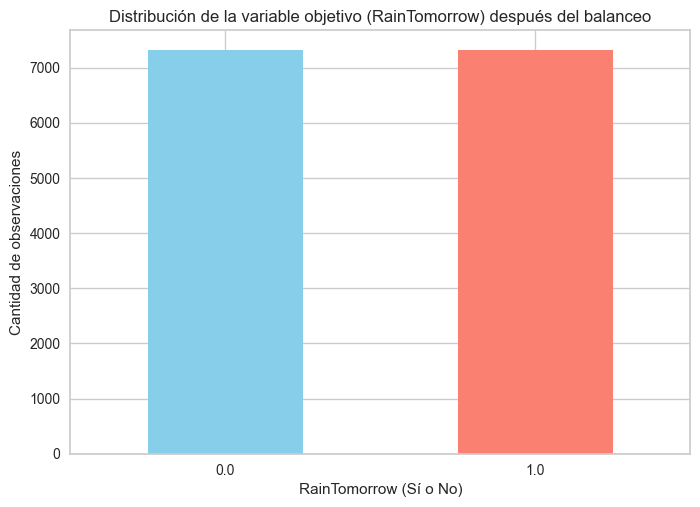

In [37]:
# Crear un dataframe con los datos balanceados
df_balanceado = pd.DataFrame({'RainTomorrow': y_train_balanced})

# Graficar la nueva distribución
df_balanceado['RainTomorrow'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])

plt.title('Distribución de la variable objetivo (RainTomorrow) después del balanceo')
plt.xlabel('RainTomorrow (Sí o No)')
plt.ylabel('Cantidad de observaciones')
plt.xticks(rotation=0)
plt.show()


In [38]:
model_logistic = LogisticRegression()
model_logistic.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [39]:
# Predicciones
y_pred_logistic = model_logistic.predict(X_test_scaled)  
y_pred_proba_logistic = model_logistic.predict_proba(X_test_scaled)[:, 1]

# Cálculo de métricas
accuracy_logistic = accuracy_score(y_test_scaled, y_pred_logistic)
precision_logistic = precision_score(y_test_scaled, y_pred_logistic)
recall_logistic = recall_score(y_test_scaled, y_pred_logistic)
f1_logistic = f1_score(y_test_scaled, y_pred_logistic)

# Mostrar las métricas
print(f"Accuracy: {accuracy_logistic:.2f}")
print(f"Precision: {precision_logistic:.2f}")
print(f"Recall: {recall_logistic:.2f}")
print(f"F1 Score: {f1_logistic:.2f}")



Accuracy: 0.82
Precision: 0.53
Recall: 0.83
F1 Score: 0.65


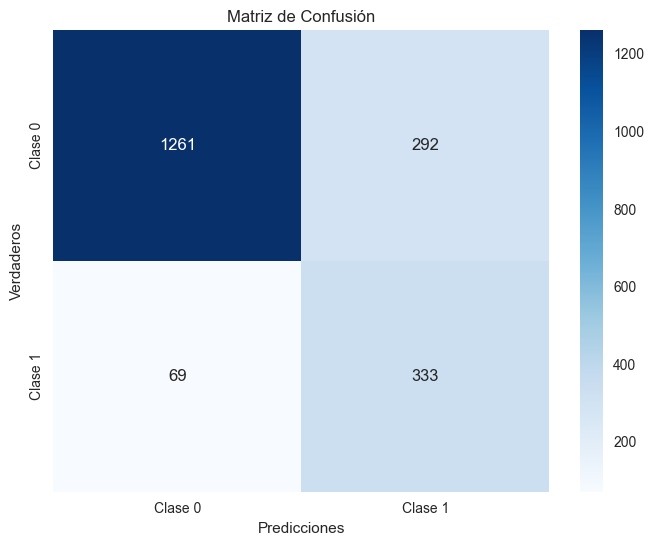

In [40]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test_scaled, y_pred_logistic)
# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1'], 
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()

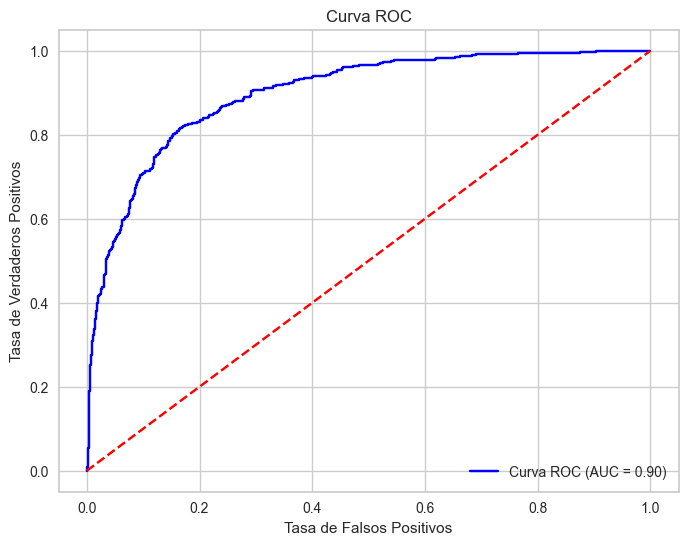

Mejor umbral: 0.54


In [41]:
# Cálculo de la curva ROC
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test_scaled, y_pred_proba_logistic)
roc_auc_logistic = roc_auc_score(y_test_scaled, y_pred_proba_logistic)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_logistic, tpr_logistic, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc_logistic))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Encontrar el mejor umbral
optimal_idx_logistic = np.argmax(tpr_logistic - fpr_logistic)
optimal_threshold_logistic = thresholds_logistic[optimal_idx_logistic]
print(f"Mejor umbral: {optimal_threshold_logistic:.2f}")


Al evaluar el modelo antes de balancear los datos, se observaron métricas que indicaban un buen rendimiento general, con un nivel aceptable de precisión. Sin embargo, esto nos podria decir que el modelo podría haber estado sesgado hacia la clase mayoritaria, dado que el recall no era tan alto.

Después de implementar el balanceo de los datos, las métricas mostraron un gran cambio. Aunque la precisión y el accuracy disminuyeron, el recall aumentó. Esto indica que, tras el balanceo, el modelo es capaz de identificar mejor los casos de la clase minoritaria, pero esto tuvo un costo en la precisión. La puntuación F1 se mantuvo constante, por lo que el modelo logró un equilibrio en su capacidad para detectar ambas clases.

La nueva matriz de confusión refleja este cambio: aunque el número de verdaderos positivos aumentó, también se observó un aumento en los falsos positivos. El cambio en el umbral óptimo también refleja esta transición, diciendonos que el modelo ahora necesita un ajuste diferente para lograr el equilibrio deseado entre las clases. Por lo tanto, el balanceo de datos mejoró la capacidad del modelo para identificar casos de la clase minoritaria, aunque a expensas de la precisión general.

## Modelo Base

Para nuestro modelo base, decidimos utilizar el **DummyClassifier** con la estrategia "stratified". A continuación, procederemos a realizar los mismos pasos que en el modelo anterior, evaluando tanto el modelo base balanceado como el desbalanceado.

### Previo al balanceo

In [42]:
# Inicializamos el DummyClassifier con la estrategia 'stratified'
dummy_clf_stratified = DummyClassifier(strategy='stratified', random_state=42)

# Entrenar el modelo Dummy
dummy_clf_stratified.fit(X_train_scaled, y_train_scaled)

# Predecir probabilidades en lugar de clases
y_pred_dummy_proba = dummy_clf_stratified.predict_proba(X_test_scaled)[:, 1]  # Probabilidades de la clase positiva

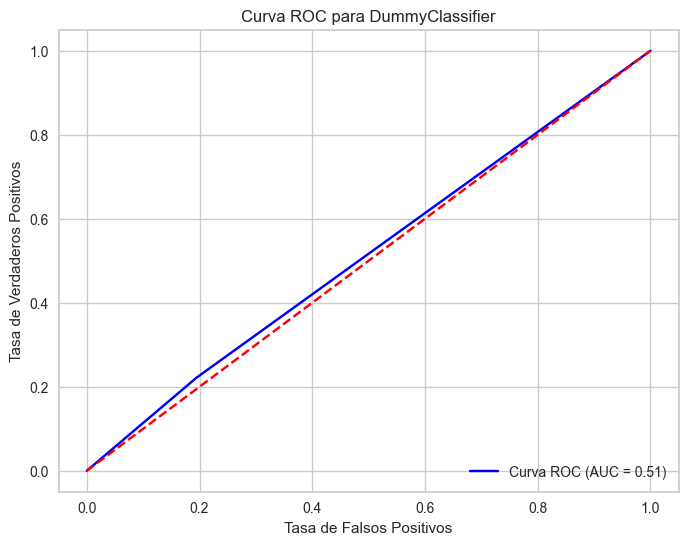

In [43]:
# Calculamos la curva ROC y encontrar el AUC
fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_test_scaled, y_pred_dummy_proba)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)

# Graficamos la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_dummy, tpr_dummy, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc_dummy))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para DummyClassifier')
plt.legend(loc='lower right')
plt.show()

In [44]:
# Encontramos el mejor umbral
optimal_idx_dummy = np.argmax(tpr_dummy - fpr_dummy)  # Mejor umbral donde TPR - FPR es máximo
optimal_threshold_dummy = thresholds_dummy[optimal_idx_dummy]

print(f"Mejor umbral: {optimal_threshold:.2f}")

Mejor umbral: 0.20


In [45]:
# Calculamos métricas con las clases generadas por el umbral óptimo
accuracy_dummy = accuracy_score(y_test_scaled, y_pred_dummy_proba)
precision_dummy = precision_score(y_test_scaled, y_pred_dummy_proba)
recall_dummy = recall_score(y_test_scaled, y_pred_dummy_proba)
f1_dummy = f1_score(y_test_scaled, y_pred_dummy_proba)

print("\nMétricas con DummyClassifier:")
print(f"Accuracy: {accuracy_dummy:.2f}")
print(f"Precision: {precision_dummy:.2f}")
print(f"Recall: {recall_dummy:.2f}")
print(f"F1 Score: {f1_dummy:.2f}")


Métricas con DummyClassifier:
Accuracy: 0.69
Precision: 0.23
Recall: 0.22
F1 Score: 0.22


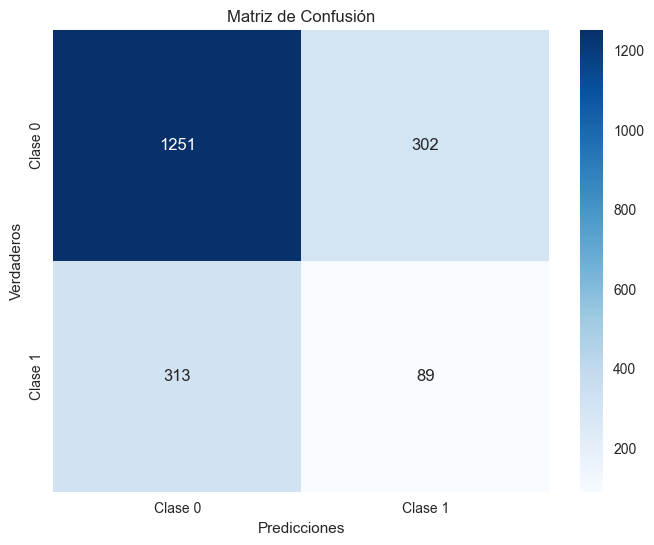

In [46]:
# Matriz de confusión
conf_matrix_dummy = confusion_matrix(y_test_scaled, y_pred_dummy_proba)
# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dummy, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1'], 
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()

### Posterior al balanceo

In [47]:
# Inicializar el DummyClassifier con la estrategia 'stratified'
dummy_clf_stratified_balanced = DummyClassifier(strategy='stratified', random_state=42)

# Entrenar el modelo Dummy
dummy_clf_stratified_balanced.fit(X_train_balanced, y_train_balanced)

# Predecir probabilidades en lugar de clases
y_pred_dummy_proba_balanced = dummy_clf_stratified_balanced.predict_proba(X_test_scaled)[:, 1]  # Probabilidades de la clase positiva

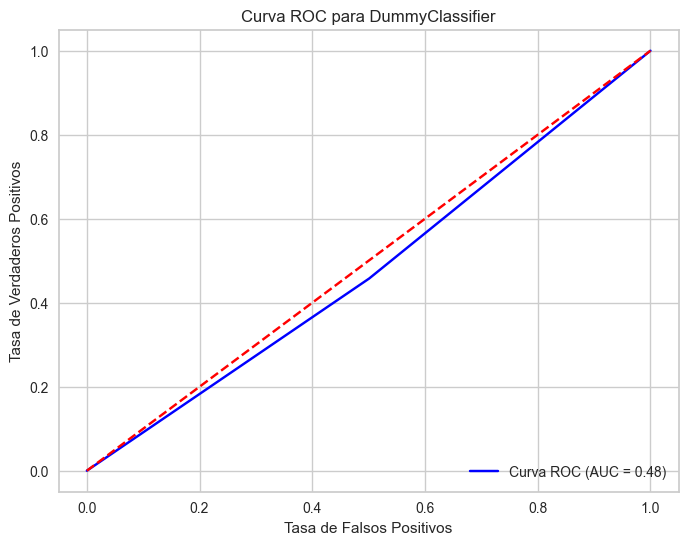

In [48]:
# Calcular la curva ROC y encontrar el AUC
fpr_dummy_balanced, tpr_dummy_balanced, thresholds_dummy_balanced = roc_curve(y_test_scaled, y_pred_dummy_proba_balanced)
roc_auc_dummy_balanced = auc(fpr_dummy_balanced, tpr_dummy_balanced)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_dummy_balanced, tpr_dummy_balanced, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc_dummy_balanced))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para DummyClassifier')
plt.legend(loc='lower right')
plt.show()

In [49]:
# Encontrar el mejor umbral
optimal_idx_dummy_balanced = np.argmax(tpr_dummy_balanced - fpr_dummy_balanced)  # Mejor umbral donde TPR - FPR es máximo
optimal_threshold_dummy_balanced = thresholds_dummy_balanced[optimal_idx_dummy_balanced]

print(f"Mejor umbral: {optimal_threshold_dummy_balanced:.2f}")

Mejor umbral: inf


In [50]:
# Calcular métricas con las clases generadas por el umbral óptimo
accuracy_dummy_balanced= accuracy_score(y_test_scaled, y_pred_dummy_proba_balanced)
precision_dummy_balanced = precision_score(y_test_scaled, y_pred_dummy_proba_balanced)
recall_dummy_balanced = recall_score(y_test_scaled, y_pred_dummy_proba_balanced)
f1_dummy_balanced = f1_score(y_test_scaled, y_pred_dummy_proba_balanced)

print("\nMétricas con DummyClassifier:")
print(f"Accuracy: {accuracy_dummy_balanced:.2f}")
print(f"Precision: {precision_dummy_balanced:.2f}")
print(f"Recall: {recall_dummy_balanced:.2f}")
print(f"F1 Score: {f1_dummy_balanced:.2f}")




Métricas con DummyClassifier:
Accuracy: 0.49
Precision: 0.19
Recall: 0.46
F1 Score: 0.27


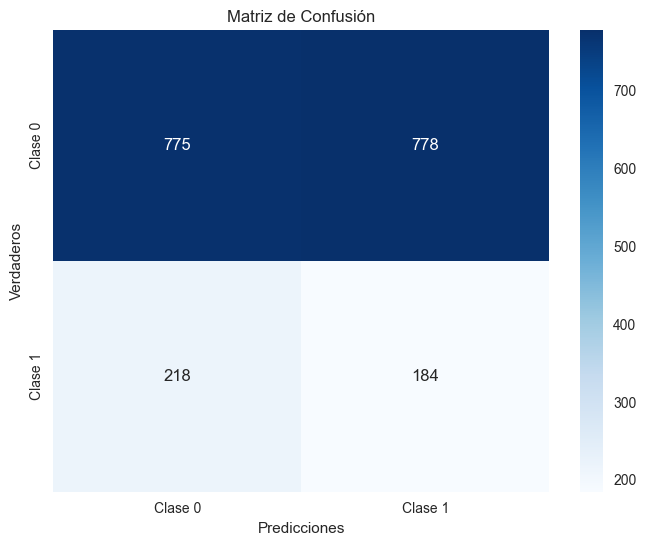

In [51]:
# Matriz de confusión
conf_matrix_dummy_balanced = confusion_matrix(y_test_scaled, y_pred_dummy_proba_balanced)
# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dummy_balanced, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1'], 
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()


Al evaluar el modelo base utilizando el **DummyClassifier** antes de balancear los datos, las métricas indicaron un rendimiento limitado. La precisión y el recall fueron bajos, interpretando que el modelo tenía dificultades para identificar correctamente las instancias de la clase positiva. La matriz de confusión reveló que el modelo estaba prediciendo en gran medida la clase mayoritaria.

Después de balancear los datos, se observó una disminución en la precisión general del modelo base, lo que indica que, aunque el recall mejoró, el modelo seguía sin ser efectivo en la identificación de la clase positiva. La puntuación F1 también mostró una leve mejora, pero las métricas siguieron indicando un rendimiento subóptimo. El umbral óptimo se encuentra como `inf`, lo que refuerza que el modelo no estaba capturando adecuadamente la clase minoritaria, incluso después del balanceo.


## Optimización de hiperparametros


Decidimos utilizar `Random Search` porque es ideal para nuestro caso, ya que contamos con un gran volumen de datos. Esta técnica selecciona combinaciones de hiperparámetros de manera aleatoria, lo cual nos permite explorar un amplio rango del espacio de búsqueda sin probar todas las combinaciones posibles. Además, `Random Search` ofrece resultados eficientes en menos tiempo cuando el rango de los hiperparámetros es amplio y no conocemos de antemano los valores óptimos.


In [52]:
param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],  
    'solver': ['lbfgs', 'liblinear', 'saga'], 
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [100, 200, 500],
    'tol': [0.0001, 0.001, 0.01],
    'fit_intercept': [True, False],
    'class_weight': ['balanced'],
    'l1_ratio': [0.5, 0.7]  # solo se usa cuando la penalidad es 'elasticnet'
}


# Configura el modelo con RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=LogisticRegression(),
                                   param_distributions=param_grid,
                                   n_iter=10,                   # Número de combinaciones a probar
                                   scoring='f1',                # Métrica para optimizar
                                   cv=5,                        # Número de pliegues de validación cruzada
                                   random_state=42)

# Entrena el RandomizedSearchCV
random_search.fit(X_train_balanced, y_train_balanced)

# Obtén el mejor modelo encontrado
best_logistic_model = random_search.best_estimator_

# Usa el mejor modelo para hacer predicciones
y_pred_logistic = best_logistic_model.predict(X_test_scaled)
y_pred_proba_logistic = best_logistic_model.predict_proba(X_test_scaled)[:, 1]

# Calcula las métricas
accuracy_logistic = accuracy_score(y_test_scaled, y_pred_logistic)
precision_logistic = precision_score(y_test_scaled, y_pred_logistic)
recall_logistic = recall_score(y_test_scaled, y_pred_logistic)
best_f1_logistic = f1_score(y_test_scaled, y_pred_logistic)

# Muestra las métricas
print(f"Mejores parámetros: {random_search.best_params_}")
print(f"Accuracy: {accuracy_logistic:.2f}")
print(f"Precision: {precision_logistic:.2f}")
print(f"Recall: {recall_logistic:.2f}")
print(f"F1 Score: {f1_logistic:.2f}")



Mejores parámetros: {'tol': 0.0001, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'l1_ratio': 0.5, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 0.1}
Accuracy: 0.81
Precision: 0.52
Recall: 0.84
F1 Score: 0.65


**Antes de la optimización de los hiperparámetros**:
- *Accuracy*: 0.82
- *Precision*: 0.53
- *Recall*: 0.83
- *F1 Score*: 0.65

**Después de la optimización de los hiperparámetros** (con los mejores parámetros encontrados: {'tol': 0.0001, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'l1_ratio': 0.5, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 0.1})
- *Accuracy*: 0.81
- *Precision*: 0.52
- *Recall*: 0.84
- *F1 Score*: 0.64

### Análisis de Resultados

La optimización de los hiperparámetros ha mejorado muy poco el *recall*, que pasó de 0.83 a 0.84, aumentando la capacidad del modelo para detectar instancias positivas. Sin embargo, el *accuracy* cayó de 0.82 a 0.81, al igual que la *precision*, que ha bajado de 0.53 a 0.52, lo que indica que el modelo ahora es, por poco, menos preciso al identificar correctamente las instancias positivas.

El *F1 Score* también bajó minimamente, pasando de 0.65 a 0.64, reflejando un balance similar entre *precision* y *recall*. 

Aunque el nuevo modelo presenta una leve mejora en el *recall*, el modelo original podría seguir siendo preferible debido a su mayor *accuracy* y *precision*.

## SHAP

### Local

In [53]:
feature_names=df_clima.drop('RainTomorrow', axis=1).columns.values
# Crea un objeto explainer SHAP
explainer = shap.LinearExplainer(model, X_train_balanced, feature_names=feature_names)
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_scaled)
index=2

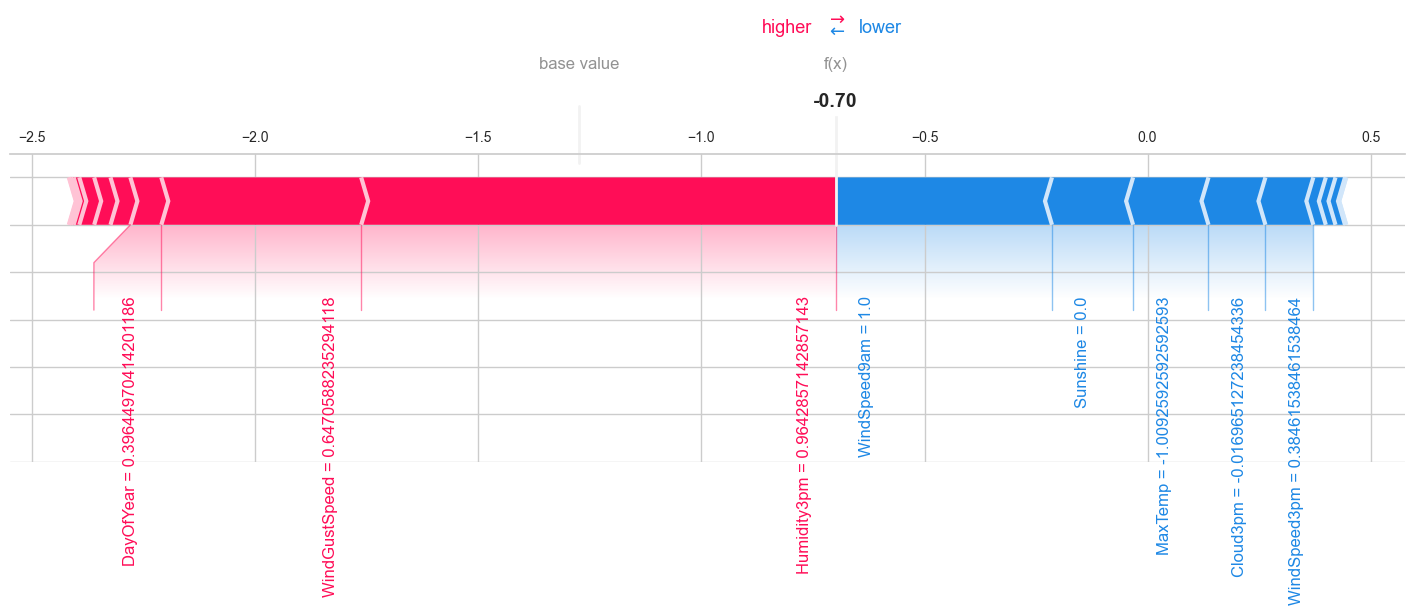

In [54]:
shap.force_plot(explainer.expected_value, shap_values[index],
                X_test_scaled.iloc[index],
                matplotlib=True, figsize=(18, 4), text_rotation=90)


- **Predicción Final (-0.70)**: Es el valor que el modelo predice para este caso específico después de considerar todas las características. El valor negativo puede decirnos que el modelo está prediciendo que el evento de interés (en este caso, lluvia al día siguiente) no ocurrirá.

**Características que Incrementan la Predicción (en rojo)**:
   - `Humidity3pm = 0.9643`: La humedad a las 3 pm tiene la mayor contribución positiva, empujando la predicción hacia arriba.
   - `WindGustSpeed = 0.6471`: La velocidad de ráfagas de viento también tiene un efecto positivo significativo.
   - `DayOfYear = 0.3964`: El día del año también contribuye, aunque en menor medida, a incrementar el valor de la predicción.

   Estas características en rojo están empujando el valor final hacia arriba, contribuyendo positivamente a la predicción de `-0.70`.

**Características que Disminuyen la Predicción (en azul)**:
   - `MaxTemp = -1.0093`: La temperatura máxima tiene la mayor contribución negativa, reduciendo significativamente el valor de la predicción.
   - `WindSpeed9am = 1.0`: La velocidad del viento a las 9 am también tiene un efecto negativo notable, disminuyendo la predicción.
   - `Cloud3pm = -0.0197` y `WindSpeed3pm = -0.3846`: La cantidad de nubes a las 3 pm y la velocidad del viento a las 3 pm también contribuyen a reducir la predicción, aunque en menor medida.

**A esos datos podemos interpretarlos de la siguiente forma:**

1. **Factores que incrementan la predicción**:
   - **Humedad (Humidity3pm)**: La alta humedad a las 3 pm generalmente está asociada con la probabilidad de lluvia, ya que un nivel elevado de humedad puede indicar condiciones atmosféricas propensas a precipitaciones.
   - **Ráfagas de viento (WindGustSpeed)**: Las ráfagas de viento también pueden ser un indicativo de inestabilidad en la atmósfera, lo cual, en algunos casos, puede ser un precursor de lluvias o tormentas.
   - **Día del año (DayOfYear)**: Dependiendo de la época del año, ciertos días pueden tener más probabilidades de lluvia (por ejemplo, en estaciones lluviosas). El modelo puede estar utilizando esta información para ajustar la predicción según las tendencias estacionales.

2. **Factores que disminuyen la predicción**:
   - **Temperatura máxima (MaxTemp)**: En general, las altas temperaturas están asociadas con condiciones más secas. Si la temperatura máxima es alta, es menos probable que haya lluvia, lo que explicaría la contribución negativa de esta característica.
   - **Velocidad del viento a las 9 am (WindSpeed9am)**: Un viento fuerte por la mañana podría estar relacionado con condiciones atmosféricas secas, como en áreas donde el viento puede desplazar las nubes, reduciendo la probabilidad de lluvia.
   - **Nubes a las 3 pm (Cloud3pm) y velocidad del viento a las 3 pm (WindSpeed3pm)**: Aunque la cantidad de nubes generalmente se asocia con lluvia, en este caso puede ser que el modelo haya encontrado que un número moderado de nubes junto con una velocidad de viento específica no aumente significativamente la probabilidad de lluvia.


In [55]:
explanation = shap.Explanation(values=shap_values[index],
                               base_values=explainer.expected_value,
                               feature_names=feature_names)

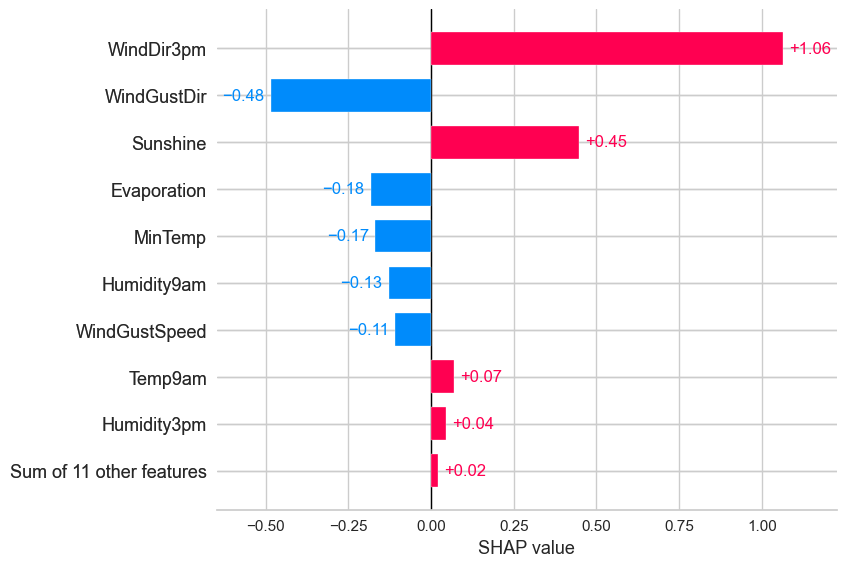

In [56]:
shap.plots.bar(explanation)


   - **WindDir3pm** tiene el mayor valor SHAP positivo (+1.06), lo que significa que contribuye fuertemente a aumentar la predicción del evento positivo (en este caso, que llueva).
   - **WindGustDir** tiene el valor SHAP negativo más alto (-0.48), indicando que disminuye significativamente la probabilidad del evento.
   - Las características en la parte superior tienen el mayor impacto en la predicción de esta instancia, ya sea positivo o negativo. En este caso, **WindDir3pm**, **WindGustDir**, y **Sunshine** son las características más influyentes.
   - Características como **Evaporation** y **MinTemp** también tienen cierto impacto, aunque menor que las tres principales.

**"Sum of 11 other features"**: Esto significa que hay otras 11 características en el modelo, pero su impacto en esta predicción es mucho menor y se resumen en este valor.


### Global

In [57]:
explanation_global = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_scaled)

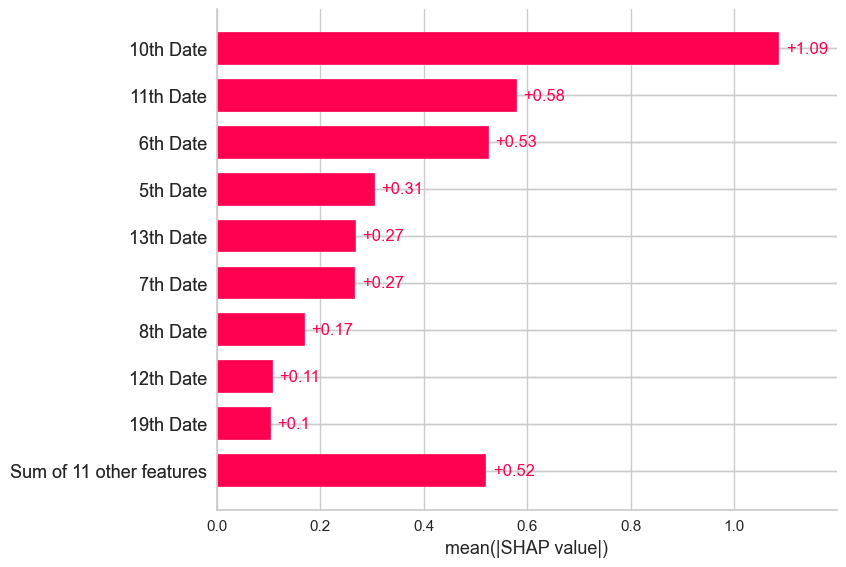

In [58]:
shap.plots.bar(explanation_global)


   - La presencia de valores altos de SHAP en el **10th Date** y **11th Date** podría correlacionarse con una temporada o un evento meteorológico. Si bien no se especifica a que hace referencia esos datos, se podria interpretar que en los meses de Octubre y Noviembre es donde históricamente llueve más, o que podrian referirse al dia 10 u 11 del mes.

   - Esta gráfica nos muestra el impacto promedio de cada característica, es decir, en todos los días y predicciones. En el caso de la **10th Date** con un SHAP de +1.09, esto significa que en general, cuando el modelo considera la **10th Date**, la probabilidad de lluvia aumenta en promedio. Esto no significa que en cada día va a llover, sino que en los días asociados con **10th Date**, el modelo observa patrones fuertes que aumentan la predicción de lluvia.
   - El hecho de que otras fechas, como **19th Date**, tengan un valor SHAP más bajo significa que el modelo ha encontrado menos indicios relevantes para asociar esos días con condiciones específicas de lluvia.
   
**"Sum of 11 other features"**:
   - Este valor agrupa el impacto de varias características menos importantes. Esto indica que si bien hay otras variables en el modelo, sus contribuciones son menores y no afectan tanto la predicción promedio. 
   - Agrupar estas características ayuda a simplificar la visualización, concentrándonos en las variables que realmente impactan la predicción, como las fechas principales mencionadas. 


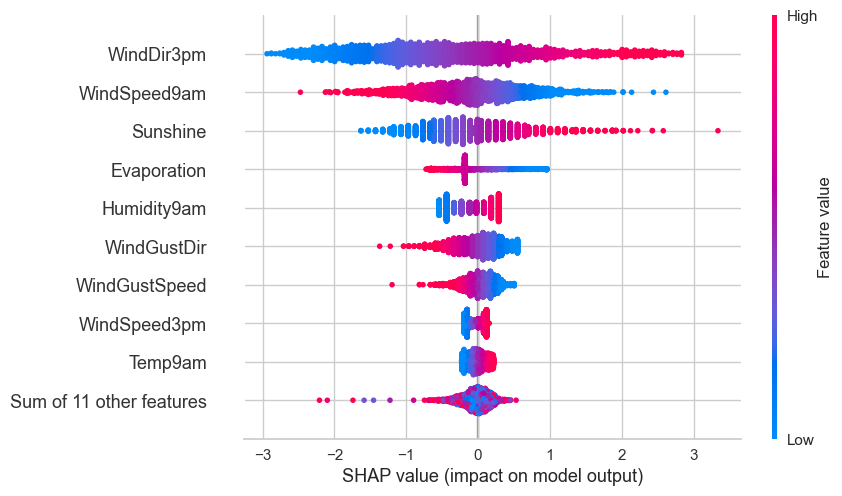

In [59]:
shap.plots.beeswarm(explanation_global)


   - `WindDir3pm` tiene un rango de valores SHAP mucho más amplio en comparación con otras características. Esto significa que esta variable tiene un impacto significativo en las predicciones del modelo, y su efecto puede ser positivo o negativo dependiendo del valor específico de la característica. 
   - En términos prácticos, `WindDir3pm` podría estar afectando en gran medida el comportamiento del modelo en distintas direcciones (aumentando o disminuyendo la predicción) y, por lo tanto, es una característica importante para el modelo.

   - `WindSpeed3pm`, en contraste, tiene un rango de valores SHAP mucho menor. Osea que esta característica tiene un impacto mucho menor en las predicciones. Aunque sigue influyendo en el modelo, su efecto es menos pronunciado, y sus valores altos o bajos no cambian mucho el resultado del modelo.

   - `Sunshine` o `Humidity9am` tienen mas dispersion o puntos en la grafica. Osea que para algunos datos, ppueden tener un impacto fuerte, mientras que para otros pueden tener un impacto bajo o incluso opuesto. Esta separación también indica posibles interacciones no lineales. Por ejemplo, puede ser que valores específicos de `Sunshine` o `Humidity9am` (representados por los colores rojo o azul) influyan de forma diferente dependiendo de otras características.


## AutoML

Elegimos PyCaret porque simplifica el flujo de trabajo de Machine Learning. Nos permite probar varios modelos y aplicar técnicas de preprocesamiento de forma rápida y sin necesidad de escribir demasiado código. Además, facilita la comparación de modelos y la optimización de hiperparámetros de manera automática.

Otra razón es que tuvimos problemas al intentar implementar AutoML con otras bibliotecas, mientras que PyCaret no presentó esos mismos errores. Decidimos usar el dataset en crudo, ya que PyCaret se encarga del preprocesamiento automáticamente. Esto nos permite comparar si nuestro preprocesamiento manual fue efectivo en relación con el de PyCaret.

In [60]:
df_crudo = df_clima.copy()
df_crudo = df_filtered.dropna(subset=['RainTomorrow'])

# Configuración de PyCaret en el dataset crudo
exp_crudo = setup(data=df_crudo, target='RainTomorrow',
                  train_size=0.7,
                  normalize=True,          
                  fix_imbalance=True,      
                  session_id=123)          

# Comparar modelos en el dataset crudo
best_model_crudo = compare_models()

,Description,Value
0,Session id,123
1,Target,RainTomorrow
2,Target type,Binary
3,Original data shape,"(13030, 20)"
4,Transformed data shape,"(18521, 22)"
5,Transformed train set shape,"(14612, 22)"
6,Transformed test set shape,"(3909, 22)"
7,Numeric features,18
8,Date features,1
9,Rows with missing values,54.8%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8761,0.9113,0.6430,0.7102,0.6737,0.5976,0.5995,0.7730
et,Extra Trees Classifier,0.8706,0.9044,0.6469,0.6872,0.6656,0.5856,0.5865,0.6510
rf,Random Forest Classifier,0.8675,0.9015,0.6607,0.6717,0.6651,0.5826,0.5833,1.2420
gbc,Gradient Boosting Classifier,0.8555,0.9000,0.7064,0.6220,0.6607,0.5695,0.5720,2.0580
ada,Ada Boost Classifier,0.8339,0.8825,0.7306,0.5652,0.6367,0.5315,0.5393,0.5870
lr,Logistic Regression,0.8278,0.9060,0.8138,0.5461,0.6530,0.5445,0.5641,1.8140
lda,Linear Discriminant Analysis,0.8269,0.9045,0.8072,0.5445,0.6499,0.5408,0.5596,0.0990
ridge,Ridge Classifier,0.8268,0.9045,0.8072,0.5443,0.6498,0.5406,0.5594,0.0840
qda,Quadratic Discriminant Analysis,0.8184,0.8718,0.7620,0.5313,0.6258,0.5110,0.5257,0.0710
svm,SVM - Linear Kernel,0.8127,0.8991,0.8226,0.5206,0.6366,0.5193,0.5448,0.1030


In [61]:
# Extraer resultados de comparación
results = pull()

# Guardar el F1-score del mejor modelo
best_f1_automl = results.loc[results.index[0], 'F1']  # Fila 0, columna F1
print(f"Mejor F1-score (AutoML): {best_f1_automl}")

Mejor F1-score (AutoML): 0.6737


### Resumen de los Resultados Obtenidos con PyCaret

1. **Estructura y Preprocesamiento de Datos**:
   - **Datos originales y transformados**: Los datos iniciales contenían 13,030 filas y 20 columnas, mientras que después de la transformación (que incluyó técnicas de balanceo y normalización) aumentaron a 18,521 filas y 22 columnas. 
   - **Imputación y balanceo**: Se aplicaron imputaciones para los valores faltantes (`mean` para numéricos y `mode` para categóricos), y se utilizó SMOTE para balancear las clases. Además, se aplicó normalización usando el método Z-score para que las características numéricas tengan una media de 0 y una desviación estándar de 1, lo que ayuda a mejorar el rendimiento de algunos modelos.

2. **Rendimiento de Modelos**:
   - **Comparativa de Modelos**:
     - **LightGBM** es el modelo con mejor precisión global (*accuracy*) con un 87.61%, y un AUC de 0.9113, lo que indica una excelente capacidad de discriminación entre las clases.
     - **Extra Trees y Random Forest** también muestran un buen rendimiento, con precisiones de 87.06% y 86.75%, respectivamente, y AUC en el rango de 0.90, lo que nos dice que estos modelos captan adecuadamente las relaciones en los datos.
     - **Modelos más simples**, como **Logistic Regression** y **LDA** (Análisis Discriminante Lineal), obtuvieron una precisión cercana al 82.7%, similar a la regresión logística inicial, aunque con ciertas mejoras en el `AUC` y `Recall`.

3. **Comparación de Métricas con la Regresión Logística Aplicada Anteriormente**:
   - El modelo de regresión logística anterior alcanzó una **precisión de 82%**, consistente con la regresión logística de PyCaret (82.78%).
   - **Recall**: El valor de `Recall` en el modelo previo fue de 0.83, superior a la mayoría de los modelos en PyCaret, lo que indica que captaba los verdaderos positivos de manera efectiva. Sin embargo, la `Precision` de este modelo era relativamente baja (0.53), lo cual significa que, aunque identificaba bien los casos positivos, también incluía muchos falsos positivos.
   - **F1 Score**: El F1 en el modelo previo fue de 0.65, algo superior al obtenido con PyCaret (0.63) pero similar a otros modelos como **Gradient Boosting Classifier** (0.6607) y **LightGBM** (0.6737). Esto indica un equilibrio razonable entre `Precision` y `Recall` en estos modelos.

4. **Interpretación General**:
   - Los modelos en PyCaret han logrado mejoras leves en precisión, `AUC`, y, en algunos casos, en `F1 Score` comparados con la regresión logística inicial. Sin embargo, el `Recall` sigue siendo un área en la que la regresión logística inicial es competitiva, aunque a costa de una menor `Precision`.

Al comparar todos los modelos, podemos concluir que nuestra regresión logística inicial no se queda atrás. Tiene un `Recall` alto a costa de una menor `Precision`, lo cual indica que el preprocesamiento de datos realizado fue, en general, adecuado.

## Redes Neuronales

In [76]:
# Definir la arquitectura del modelo
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # primera capa oculta
    Dense(32, activation='relu'),  # segunda capa oculta
    Dense(1, activation='sigmoid')  # capa de salida
])

# Compilar el modelo
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con early stopping
history = nn.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,  # 20% de los datos de entrenamiento para validación
    epochs=30,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)


# Predicción
y_pred = (nn.predict(X_test_scaled) > 0.5).astype("int32")

# Calcula métricas
accuracy = accuracy_score(y_test_scaled, y_pred)
precision = precision_score(y_test_scaled, y_pred)
recall = recall_score(y_test_scaled, y_pred)
f1_nn = f1_score(y_test_scaled, y_pred)
auc = roc_auc_score(y_test_scaled, y_pred)

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_nn}, AUC: {auc}")


Epoch 1/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7503 - loss: 0.5116 - val_accuracy: 0.8668 - val_loss: 0.3273
Epoch 2/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8607 - loss: 0.3250 - val_accuracy: 0.8679 - val_loss: 0.3202
Epoch 3/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8685 - loss: 0.3023 - val_accuracy: 0.8685 - val_loss: 0.3064
Epoch 4/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8732 - loss: 0.2873 - val_accuracy: 0.8592 - val_loss: 0.3451
Epoch 5/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8749 - loss: 0.2977 - val_accuracy: 0.8767 - val_loss: 0.2906
Epoch 6/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8781 - loss: 0.2806 - val_accuracy: 0.8740 - val_loss: 0.2894
Epoch 7/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8803 - loss: 0.2729 - val_accuracy: 0.8674 - val_loss: 0.3129
Epoch 8/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8743 - loss: 0.2904 - val_accuracy: 0.

#### Conclusión de la Primera Implementación de Red Neuronal

La implementación inicial de la red neuronal mostró un rendimiento sólido, con buenas métricas de precisión y AUC. Sin embargo, se observó que las métricas de recall y precisión aún pueden mejorarse. Esto sugiere que, aunque el modelo tiene un rendimiento general adecuado, podría beneficiarse de ajustes en su capacidad para identificar correctamente los días lluviosos, lo cual es crucial en este tipo de predicciones.

Aunque la red neuronal es una opción válida, modelos como LightGBM ya demostraron tener un rendimiento superior en términos de precisión y capacidad de discriminación. Aún así, la red neuronal sigue siendo una alternativa interesante, especialmente si se optimizan los hiperparámetros y se mejora el balance entre precisión y recall.


### Optimizacion de hiperparametros

In [63]:
def objective(trial):
    # Hiperparámetros que Optuna va a optimizar
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    num_layers = trial.suggest_int('num_layers', 1, 2)
    neurons_per_layer = trial.suggest_int('neurons_per_layer', 24, 32)

    # Definir la arquitectura del modelo
    model = Sequential()
    model.add(Dense(neurons_per_layer, activation='relu', input_shape=(X_train_scaled.shape[1],)))

    for _ in range(num_layers - 1):  # Añadir más capas ocultas si es necesario
        model.add(Dense(neurons_per_layer, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))  # Capa de salida

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo con early stopping, usando los datos de validación
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),  # Usar los datos de validación
        epochs=30,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=0  # Desactivar salida de entrenamiento
    )

    # Hacer predicciones
    y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

    # Calcular las métricas
    accuracy = accuracy_score(y_test_scaled, y_pred)
    precision = precision_score(y_test_scaled, y_pred)
    recall = recall_score(y_test_scaled, y_pred)
    f1 = f1_score(y_test_scaled, y_pred)
    auc = roc_auc_score(y_test_scaled, y_pred)

    # Devolver el valor negativo de la métrica de rendimiento, porque Optuna busca maximizar el objetivo
    return f1


In [64]:
# Crear el estudio para optimizar el modelo
study = optuna.create_study(direction='maximize')  # Maximizamos F1 Score
study.optimize(objective, n_trials=50)  # Realizar 50 pruebas para encontrar los mejores parámetros
print(f"Best trial: {study.best_trial.params}")
print(f"Best F1 score: {study.best_value}")


[I 2024-11-27 16:55:20,607] A new study created in memory with name: no-name-bf5a0217-f901-4713-ac56-0a3397647766


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


[I 2024-11-27 16:55:38,175] Trial 0 finished with value: 0.671251719394773 and parameters: {'learning_rate': 0.006599482722032356, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 31}. Best is trial 0 with value: 0.671251719394773.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-11-27 16:56:02,223] Trial 1 finished with value: 0.6740947075208914 and parameters: {'learning_rate': 0.004329117086381447, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 26}. Best is trial 1 with value: 0.6740947075208914.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


[I 2024-11-27 16:56:15,370] Trial 2 finished with value: 0.6666666666666666 and parameters: {'learning_rate': 0.0015243500463863102, 'batch_size': 64, 'num_layers': 1, 'neurons_per_layer': 30}. Best is trial 1 with value: 0.6740947075208914.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-11-27 16:56:25,967] Trial 3 finished with value: 0.6711590296495957 and parameters: {'learning_rate': 0.006649172178335255, 'batch_size': 64, 'num_layers': 2, 'neurons_per_layer': 29}. Best is trial 1 with value: 0.6740947075208914.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 16:56:49,395] Trial 4 finished with value: 0.6721311475409836 and parameters: {'learning_rate': 0.0057439881068514324, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 28}. Best is trial 1 with value: 0.6740947075208914.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


[I 2024-11-27 16:57:07,903] Trial 5 finished with value: 0.663013698630137 and parameters: {'learning_rate': 0.0016464408156329194, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 25}. Best is trial 1 with value: 0.6740947075208914.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-11-27 16:57:18,737] Trial 6 finished with value: 0.6831275720164609 and parameters: {'learning_rate': 0.0013923019836090472, 'batch_size': 64, 'num_layers': 1, 'neurons_per_layer': 31}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 16:57:38,443] Trial 7 finished with value: 0.6823855755894591 and parameters: {'learning_rate': 0.001337666293768578, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 26}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2024-11-27 16:58:04,536] Trial 8 finished with value: 0.6544943820224719 and parameters: {'learning_rate': 0.0015459287777164566, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 26}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 16:58:26,126] Trial 9 finished with value: 0.6796657381615598 and parameters: {'learning_rate': 0.004256622177784847, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 31}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


[I 2024-11-27 16:58:52,648] Trial 10 finished with value: 0.649171270718232 and parameters: {'learning_rate': 0.002112542148257274, 'batch_size': 64, 'num_layers': 2, 'neurons_per_layer': 32}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-11-27 16:59:12,055] Trial 11 finished with value: 0.671251719394773 and parameters: {'learning_rate': 0.0010383319391868975, 'batch_size': 64, 'num_layers': 1, 'neurons_per_layer': 28}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 16:59:27,780] Trial 12 finished with value: 0.649645390070922 and parameters: {'learning_rate': 0.0026009633387807183, 'batch_size': 64, 'num_layers': 1, 'neurons_per_layer': 24}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


[I 2024-11-27 16:59:49,417] Trial 13 finished with value: 0.675 and parameters: {'learning_rate': 0.0010028312766786616, 'batch_size': 64, 'num_layers': 1, 'neurons_per_layer': 27}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-11-27 17:00:17,904] Trial 14 finished with value: 0.6767537826685007 and parameters: {'learning_rate': 0.009752360259514467, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 29}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


[I 2024-11-27 17:00:34,465] Trial 15 finished with value: 0.6431593794076164 and parameters: {'learning_rate': 0.001290499595960891, 'batch_size': 64, 'num_layers': 1, 'neurons_per_layer': 24}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[I 2024-11-27 17:00:49,642] Trial 16 finished with value: 0.6468926553672316 and parameters: {'learning_rate': 0.0021574356655085563, 'batch_size': 64, 'num_layers': 1, 'neurons_per_layer': 27}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-11-27 17:01:03,986] Trial 17 finished with value: 0.6603260869565217 and parameters: {'learning_rate': 0.0032013855620778133, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 32}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


[I 2024-11-27 17:01:27,084] Trial 18 finished with value: 0.6657534246575343 and parameters: {'learning_rate': 0.002111882802550755, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 26}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:01:39,563] Trial 19 finished with value: 0.6666666666666666 and parameters: {'learning_rate': 0.0012869974878720533, 'batch_size': 64, 'num_layers': 1, 'neurons_per_layer': 30}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:01:52,078] Trial 20 finished with value: 0.6693989071038251 and parameters: {'learning_rate': 0.003460968291477202, 'batch_size': 64, 'num_layers': 2, 'neurons_per_layer': 25}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:02:15,473] Trial 21 finished with value: 0.6563814866760168 and parameters: {'learning_rate': 0.004496938613446103, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 31}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:02:30,418] Trial 22 finished with value: 0.6610878661087866 and parameters: {'learning_rate': 0.0025652633798937587, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 31}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[I 2024-11-27 17:02:50,263] Trial 23 finished with value: 0.6783310901749664 and parameters: {'learning_rate': 0.004673742390206769, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 30}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


[I 2024-11-27 17:03:02,048] Trial 24 finished with value: 0.669432918395574 and parameters: {'learning_rate': 0.003541281800166421, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 29}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:03:17,391] Trial 25 finished with value: 0.6526610644257703 and parameters: {'learning_rate': 0.0017846888417033856, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 32}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:03:33,946] Trial 26 finished with value: 0.6629370629370629 and parameters: {'learning_rate': 0.0026991084320310333, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 27}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:03:47,726] Trial 27 finished with value: 0.6555555555555556 and parameters: {'learning_rate': 0.0012300231234017975, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 31}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:03:54,401] Trial 28 finished with value: 0.665742024965326 and parameters: {'learning_rate': 0.0019292643273492252, 'batch_size': 64, 'num_layers': 2, 'neurons_per_layer': 30}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-11-27 17:04:13,350] Trial 29 finished with value: 0.6619718309859155 and parameters: {'learning_rate': 0.00670641422411727, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 32}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:04:36,205] Trial 30 finished with value: 0.6556927297668038 and parameters: {'learning_rate': 0.008521408564152365, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 29}. Best is trial 6 with value: 0.6831275720164609.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:04:52,780] Trial 31 finished with value: 0.6864064602960969 and parameters: {'learning_rate': 0.004484644923990114, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 30}. Best is trial 31 with value: 0.6864064602960969.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:05:07,899] Trial 32 finished with value: 0.6765899864682002 and parameters: {'learning_rate': 0.003856309289555977, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 31}. Best is trial 31 with value: 0.6864064602960969.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:05:35,520] Trial 33 finished with value: 0.6774628879892037 and parameters: {'learning_rate': 0.005351717109047668, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 31}. Best is trial 31 with value: 0.6864064602960969.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-11-27 17:05:48,680] Trial 34 finished with value: 0.6507713884992987 and parameters: {'learning_rate': 0.0051745392201172245, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 30}. Best is trial 31 with value: 0.6864064602960969.


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-11-27 17:06:01,701] Trial 35 finished with value: 0.6556473829201102 and parameters: {'learning_rate': 0.004151893623845496, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 30}. Best is trial 31 with value: 0.6864064602960969.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:06:14,755] Trial 36 finished with value: 0.6536312849162011 and parameters: {'learning_rate': 0.002907490715823877, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 29}. Best is trial 31 with value: 0.6864064602960969.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:06:24,158] Trial 37 finished with value: 0.659400544959128 and parameters: {'learning_rate': 0.006073529319354579, 'batch_size': 64, 'num_layers': 2, 'neurons_per_layer': 28}. Best is trial 31 with value: 0.6864064602960969.


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-11-27 17:06:42,979] Trial 38 finished with value: 0.660056657223796 and parameters: {'learning_rate': 0.0073594084108772875, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 25}. Best is trial 31 with value: 0.6864064602960969.


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[I 2024-11-27 17:06:57,198] Trial 39 finished with value: 0.6601941747572816 and parameters: {'learning_rate': 0.0013821283006549806, 'batch_size': 64, 'num_layers': 1, 'neurons_per_layer': 32}. Best is trial 31 with value: 0.6864064602960969.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-11-27 17:07:24,080] Trial 40 finished with value: 0.6875816993464052 and parameters: {'learning_rate': 0.0011133117511479705, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 31}. Best is trial 40 with value: 0.6875816993464052.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


[I 2024-11-27 17:07:48,134] Trial 41 finished with value: 0.6620498614958449 and parameters: {'learning_rate': 0.0011318491987533043, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 31}. Best is trial 40 with value: 0.6875816993464052.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-11-27 17:07:58,821] Trial 42 finished with value: 0.6684856753069577 and parameters: {'learning_rate': 0.0014623098780538904, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 31}. Best is trial 40 with value: 0.6875816993464052.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-11-27 17:08:20,479] Trial 43 finished with value: 0.6666666666666666 and parameters: {'learning_rate': 0.0015900121441303522, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 30}. Best is trial 40 with value: 0.6875816993464052.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:08:46,315] Trial 44 finished with value: 0.6611111111111111 and parameters: {'learning_rate': 0.0011526576983906032, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 32}. Best is trial 40 with value: 0.6875816993464052.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-11-27 17:08:58,324] Trial 45 finished with value: 0.675 and parameters: {'learning_rate': 0.0010597886654870254, 'batch_size': 64, 'num_layers': 2, 'neurons_per_layer': 28}. Best is trial 40 with value: 0.6875816993464052.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:09:11,799] Trial 46 finished with value: 0.6675938803894298 and parameters: {'learning_rate': 0.0013825821333054435, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 29}. Best is trial 40 with value: 0.6875816993464052.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


[I 2024-11-27 17:09:20,362] Trial 47 finished with value: 0.6493860845839018 and parameters: {'learning_rate': 0.0018121100054798297, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 30}. Best is trial 40 with value: 0.6875816993464052.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-11-27 17:09:35,990] Trial 48 finished with value: 0.6685314685314685 and parameters: {'learning_rate': 0.003930608747659324, 'batch_size': 64, 'num_layers': 1, 'neurons_per_layer': 27}. Best is trial 40 with value: 0.6875816993464052.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-11-27 17:09:57,356] Trial 49 finished with value: 0.674863387978142 and parameters: {'learning_rate': 0.0023554913605842633, 'batch_size': 32, 'num_layers': 1, 'neurons_per_layer': 31}. Best is trial 40 with value: 0.6875816993464052.


Best trial: {'learning_rate': 0.0011133117511479705, 'batch_size': 32, 'num_layers': 2, 'neurons_per_layer': 31}
Best F1 score: 0.6875816993464052


#### Modelo Optimizado

In [78]:
# Definir la arquitectura del modelo con los hiperparámetros óptimos
best_nn = Sequential([
    Dense(31, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # primera capa oculta
    Dense(31, activation='relu'),  # segunda capa oculta
    Dense(1, activation='sigmoid')  # capa de salida
])

# Compilar el modelo con el learning_rate óptimo
best_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0011133117511479705),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Entrenar el modelo con early stopping
history = best_nn.fit(
    X_train_scaled, y_train,
    validation_split=0.2,  # 20% de los datos de entrenamiento para validación
    epochs=30,
    batch_size=64,  # Tamaño de batch optimizado
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Predicción
y_pred = (best_nn.predict(X_test_scaled) > 0.5).astype("int32")

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_best_nn = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Imprimir resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_best_nn:.4f}")
print(f"AUC: {auc:.4f}")

Epoch 1/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7904 - loss: 0.5338 - val_accuracy: 0.8477 - val_loss: 0.3567
Epoch 2/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8389 - loss: 0.3513 - val_accuracy: 0.8663 - val_loss: 0.3138
Epoch 3/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8656 - loss: 0.3074 - val_accuracy: 0.8701 - val_loss: 0.3082
Epoch 4/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8676 - loss: 0.2998 - val_accuracy: 0.8718 - val_loss: 0.2993
Epoch 5/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8658 - loss: 0.3022 - val_accuracy: 0.8729 - val_loss: 0.3011
Epoch 6/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8756 - loss: 0.2925 - val_accuracy: 0.8685 - val_loss: 0.3015
Epoch 7/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8757 - loss: 0.2967 - val_accuracy: 0.8723 - val_loss: 0.3032
Epoch 8/30
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8799 - loss: 0.2853 - val_accuracy: 0

#### Comparación entre el modelo inicial y el modelo optimizado

##### **Interpretación de los resultados:**

- **Accuracy:** El modelo optimizado tiene una ligera mejora en la precisión total en comparación con el modelo inicial (0.8803 frente a 0.8757). Aunque la diferencia es pequeña.

- **F1 Score:** El F1 score, que balancea precisión y recall, también muestra una mejora en el modelo optimizado (de 0.6694 a 0.6812). Esto confirma que el modelo optimizado no solo mejora en precisión, sino también en recall, lo que da lugar a una mayor capacidad de generalización.

- **AUC (Área bajo la curva ROC):** El AUC ha aumentado de 0.7780 a 0.7845. Esto es un buen indicio de que el modelo optimizado está mejor en términos de discriminación global entre las clases.

### SHAP


Se seleccionó `KernelExplainer` por ser el ideal para redes neuronales como la utilizada en este proyecto.

El uso del conjunto completo de datos (`X_train_scaled`, 9121 muestras) como referencia es computacionalmente costoso. Para optimizar el rendimiento, se utilizó una muestra reducida de 100 elementos mediante `shap.sample`.


In [66]:
"""
X_train_sampled = shap.sample(X_train_scaled, 100)  # Usar solo 100 muestras

# Crear el explicador con el conjunto reducido
explainer = shap.KernelExplainer(best_nn.predict, X_train_sampled)

# Calcular los valores SHAP
shap_values = explainer.shap_values(X_test_scaled, nsamples=100)
"""

'\nX_train_sampled = shap.sample(X_train_scaled, 100)  # Usar solo 100 muestras\n\n# Crear el explicador con el conjunto reducido\nexplainer = shap.KernelExplainer(best_nn.predict, X_train_sampled)\n\n# Calcular los valores SHAP\nshap_values = explainer.shap_values(X_test_scaled, nsamples=100)\n'

In [67]:

"""
# Guardar los shap values en un archivo
with open('shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

# Guardar el valor esperado (expected value) también
with open('explainer_expected_value.pkl', 'wb') as f:
    pickle.dump(explainer.expected_value, f)
"""

"\n# Guardar los shap values en un archivo\nwith open('shap_values.pkl', 'wb') as f:\n    pickle.dump(shap_values, f)\n\n# Guardar el valor esperado (expected value) también\nwith open('explainer_expected_value.pkl', 'wb') as f:\n    pickle.dump(explainer.expected_value, f)\n"

In [68]:
!gdown "1RmOJJGpwtpjB8tUgAX5lcfSMxpXayoxW" --output "shap_values.pkl"
!gdown "129PKhdKz1CMq5LQIX_AxkdjmuO4C2-dd" --output "explainer_expected_value.pkl"

# Cargar los shap values desde el archivo
with open('shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)

# Cargar el valor esperado si es necesario
with open('explainer_expected_value.pkl', 'rb') as f:
    expected_value = pickle.load(f)


Downloading...
From: https://drive.google.com/uc?id=1RmOJJGpwtpjB8tUgAX5lcfSMxpXayoxW
To: c:\Users\Usuario\Desktop\TUIA\AA1-TUIA-Avecilla-Calcia\AA1-TUIA-Calcia-Avecilla\shap_values.pkl

  0%|          | 0.00/313k [00:00<?, ?B/s]
100%|██████████| 313k/313k [00:00<00:00, 2.72MB/s]
100%|██████████| 313k/313k [00:00<00:00, 2.72MB/s]
Downloading...
From: https://drive.google.com/uc?id=129PKhdKz1CMq5LQIX_AxkdjmuO4C2-dd
To: c:\Users\Usuario\Desktop\TUIA\AA1-TUIA-Avecilla-Calcia\AA1-TUIA-Calcia-Avecilla\explainer_expected_value.pkl

  0%|          | 0.00/155 [00:00<?, ?B/s]
100%|██████████| 155/155 [00:00<?, ?B/s] 


#### Local

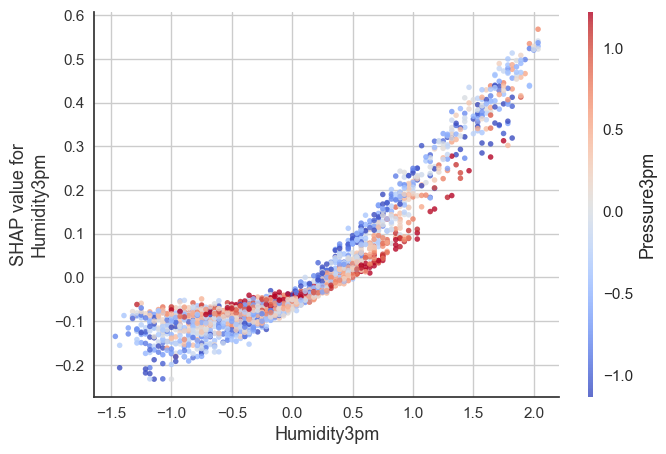

In [69]:
# Crear el gráfico de dependencia con colores personalizados en SHAP
shap.dependence_plot(
    "Humidity3pm",  # Nombre de la característica
    shap_values[:,:,0],  # Valores SHAP para la clase 0
    X_test_scaled,
    cmap='coolwarm',
    alpha=0.8,
    show=True
)

Aqui se muestra la clara relacion entre la variable que segun shap mas afecta al modelo.

#### Global

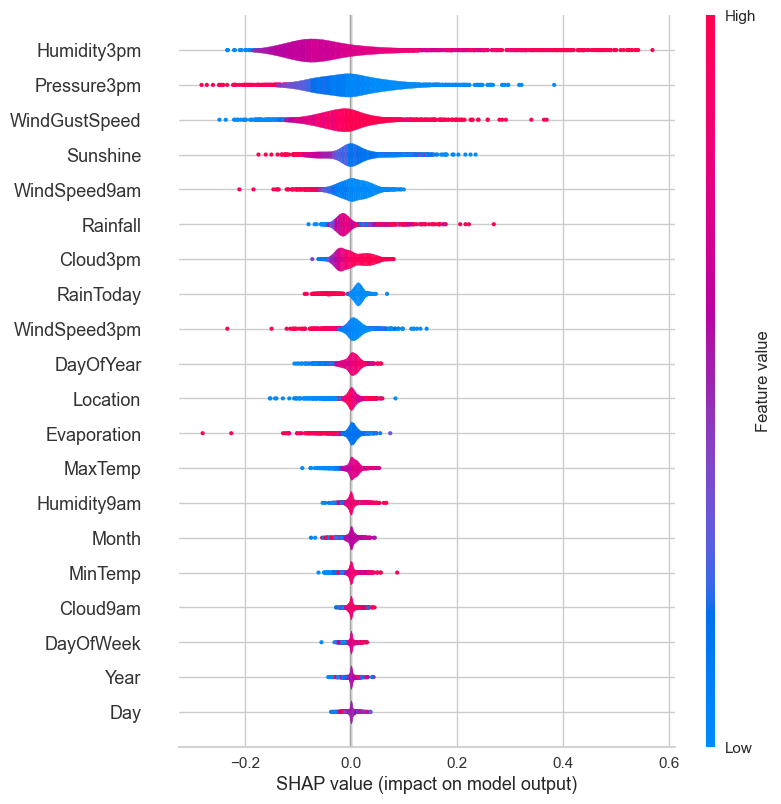

In [70]:
shap.violin_plot(shap_values[:,:,0], X_test_scaled)

En este grafico podemos ver de manera mas general como afectan las variables al modelo

### Red Neuronal vs Regresión Logística | Observaciones clave:

1. **Importancia global de las características:**
   - En el modelo de **regresión logística**, la característica más influyente es `WindDir3pm`, seguida de `WindSpeed9am`, `Evaporation` y `Sunshine`.
   - En la **red neuronal**, la característica más relevante es `Humidity3pm`, seguida de `Pressure3pm`, `WindGustSpeed` y `Sunshine`.
   - Esto muestra que ambos modelos priorizan diferentes características, lo cual es esperable dada la diferencia de linealidad entre los modelos.

2. **Distribución de los valores SHAP:**
   - En la regresión logística, los valores SHAP tienen una amplitud mayor y más simétrica (por ejemplo, `WindDir3pm` varía entre -2 y 2).
   - En la red neuronal, los valores SHAP son más pequeños (principalmente entre -0.2 y 0.6).
   - Esto puede indicar que:
     - En la regresión logística, el impacto de cada característica individual es más evidente.
     - En la red neuronal, las predicciones están más influenciadas por combinaciones de características en lugar de características individuales con gran peso.

3. **Número de características relevantes:**
   - En la regresión logística, solo unas pocas características tienen un impacto dominante (las primeras en el gráfico).
   - En la red neuronal, un mayor número de características contribuyen de manera significativa (se observa dispersión de valores SHAP en varias).
   - Las redes neuronales tienden a distribuir la importancia entre varias características debido a su capacidad para capturar relaciones complejas.

4. **Relación entre el valor de la característica y su impacto:**
   - En ambos gráficos, los colores representan los valores de las características (alto en rojo, bajo en azul).
   - En la regresión logística, las relaciones parecen más lineales (un aumento o disminución del valor de la característica afecta predeciblemente la salida).
   - En la red neuronal, se observan patrones más complejos, donde tanto valores altos como bajos pueden contribuir positiva o negativamente dependiendo del contexto.

##### Conclusión Parcial:
- **Regresión logística:** Es más fácil de interpretar porque las características más importantes tienen efectos lineales y predecibles. Las relaciones que captura son generalmente directas.
- **Red neuronal:** Aunque es menos intuitiva, las redes neuronales pueden capturar relaciones no lineales y patrones más complejos. Es gracias a SHAP que es posible interpretar el impacto de las características individuales en las predicciones.




## Comparación de Modelos utilizando F1-Score

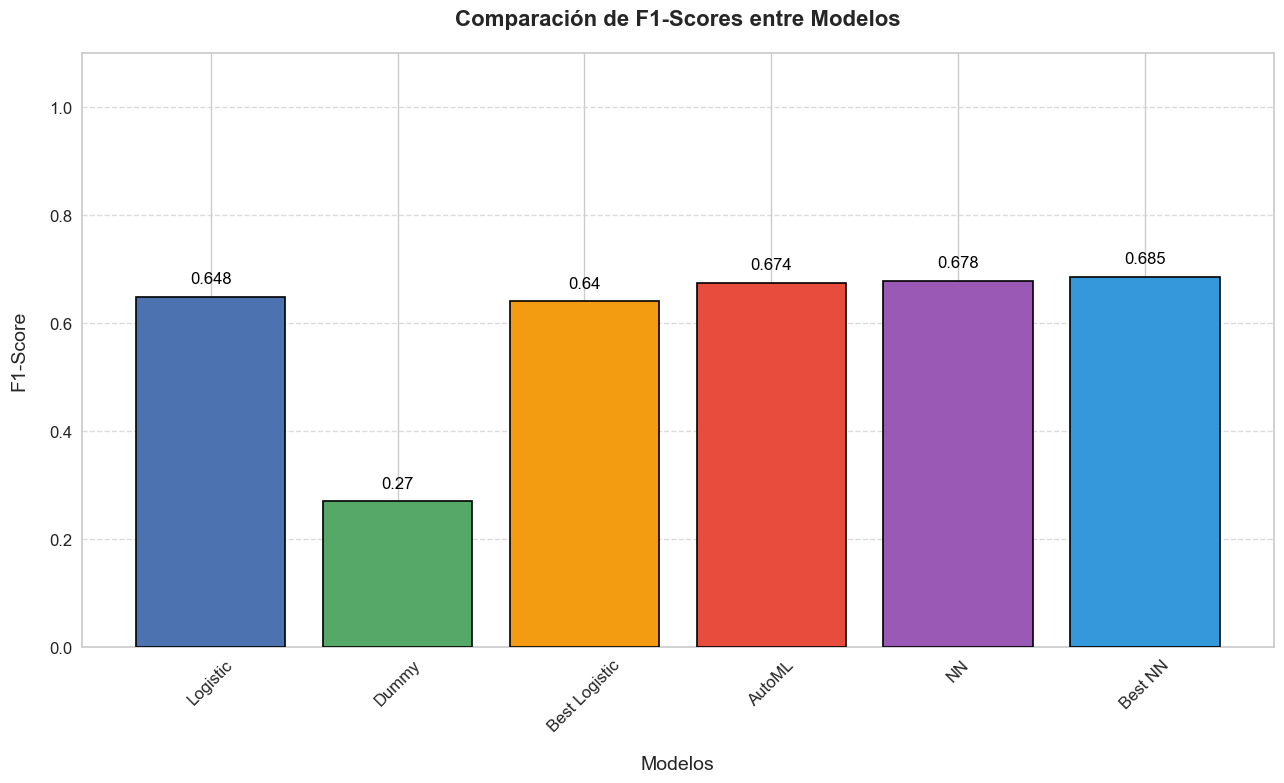

In [79]:

# Datos de los modelos y F1-scores
models = ['Logistic', 'Dummy', 'Best Logistic', 'AutoML', 'NN', 'Best NN']
f1_scores = [f1_logistic, f1_dummy_balanced, best_f1_logistic, best_f1_automl, f1_nn, f1_best_nn]

# Definir colores y estilo
colors = ['#4C72B0', '#55A868', '#F39C12', '#E74C3C', '#9B59B6', '#3498DB']
fig, ax = plt.subplots(figsize=(13, 8))

# Crear el gráfico de barras con bordes redondeados
bars = ax.bar(models, f1_scores, color=colors, edgecolor='black', linewidth=1.2, zorder=3)

# Añadir etiquetas sobre las barras
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, round(yval, 3), ha='center', va='bottom', fontsize=12, color='black', zorder=4)

# Configuración del gráfico
ax.set_title('Comparación de F1-Scores entre Modelos', fontsize=16, weight='bold', pad=20)
ax.set_xlabel('Modelos', fontsize=14, labelpad=15)
ax.set_ylabel('F1-Score', fontsize=14, labelpad=15)
ax.set_ylim(0, 1.1)  # Ampliar el límite superior para dejar espacio a las etiquetas
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Agregar un grid para facilitar la lectura
ax.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=0)

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el gráfico para evitar que se solapen los textos
plt.show()


En este grafico observamos la ventaja de los modelos AutoML y Best NN de manera clara



Decidimos usar la metrica **f1** ya que consideramos que equilibra precisión y recall, penalizando tanto los falsos positivos como los falsos negativos, lo que nos da una evaluación más completa del rendimiento del modelo. En base a esto nos hicimos algunas preguntas...

### 1. **¿Cuál es el modelo con mejor desempeño?**

El modelo **Best NN** (Red Neuronal Optimizada) ha mostrado el mejor desempeño en términos de F1-Score, seguido muy de cerca por el modelo **AutoML**. Ambos modelos superan ligeramente a los otros, lo que indica que la optimización de los hiperparámetros para la red neuronal mejoro su capacidad para manejar la clasificación en este conjunto de datos.

### 2. **¿Por qué los modelos de AutoML y la Red Neuronal Optimizada son los mejores?**

La **red neuronal optimizada** y el **modelo AutoML** pueden haber logrado un mejor desempeño por distintos motivos:

- El modelo **AutoML** realiza una búsqueda exhaustiva de los mejores hiperparámetros y estrategias de preprocesamiento, lo que le permite encontrar una configuración más adecuada para el problema.
- Por otro lado, al optimizar los hiperparámetros de la **Red Neuronal** el modelo fue ajustado para obtener el mejor desempeño posible sobre el conjunto de datos.

### 3. **¿Qué modelos tuvieron el peor desempeño?**

El modelo **Dummy** (modelo base) tiene el peor desempeño, lo cual es esperado, ya que es un modelo de referencia aleatorio que no aprende de los datos. Mientras que el modelo **Logistic** también tiene un desempeño por debajo de los modelos optimizados, aunque sigue siendo mejor que el modelo Dummy.


### 4. **¿Existen diferencias sustanciales entre los modelos?**

Aunque hay diferencias entre los modelos, las variaciones en los F1-Scores no son drásticas, lo que sugiere que los modelos más simples, como la regresión logística, siguen siendo competitivos frente a los modelos más complejos. Sin embargo, los modelos como la red neuronal optimizada y AutoML son mejores al ajustar finamente los hiperparámetros y el preprocesamiento, lo que les da una ligera ventaja.



## MLOps

Guardamos los archivos serializados

In [ ]:
"""
# Guardar el modelo entrenado
with open("modelo.pkl", "wb") as f:
    pickle.dump(best_nn, f)

# Guardar el scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
    
with open("mean_encoded_location.pkl", "wb") as f:
    pickle.dump(mean_encoded_location_today, f)

    
with open("medias.pkl", "wb") as f:
    pickle.dump(medias, f)

with open("mediana_sunshine.pkl", "wb") as f:
    pickle.dump(mediana_sunshine, f)

with open("mediana_evaporation.pkl", "wb") as f:
    pickle.dump(mediana_evaporation, f)

"""